In [1]:
# AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=25
n_units=512
l2Regularizer=1e-09
kernel_size1 = 2
kernel_size2 = 5
n_grid = 101
strides = 2
input_size = 49

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out')

In [7]:
origin = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin_data)
folders = [file for file in folders_orig if file.startswith('airfoil')]

In [9]:
coord_df = pd.DataFrame()
counter = 1
for i in range(1, 134):
    coord_file_name = origin_coord + "\\airfoil" + str(i) + "\\airfoilOut"+ str(i) + ".txt"
    data = pd.read_csv(coord_file_name, sep = ",", header=None)
    while counter < 17:
        coord_df = pd.concat([coord_df, data], axis=0)
        counter += 1
    counter=1

In [10]:
coord_np = coord_df.iloc[:, :].values

In [11]:
coord = coord_np.reshape((len(folders), 16, 2, 50))

In [12]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [13]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [14]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [15]:
y = y.reshape((133, 16, 2, 1))

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [17]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [18]:
geometry.shape

(2128, 1)

In [19]:
geometry = geometry.reshape((133, 16, 1))

In [20]:
x_train_orig, x_test, aa_train_orig, aa_test, geo_train_orig, geo_test, y_train_orig, y_test = train_test_split(
    coord, aa, geometry, y, test_size=0.1, random_state=1)

In [21]:
x_train, x_val, aa_train, aa_val, geo_train, geo_val, y_train, y_val = train_test_split(x_train_orig, aa_train_orig, geo_train_orig,
                                                                                        y_train_orig, test_size=0.3, random_state=1)

In [22]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_val = x_val.reshape((x_val.shape[0]*x_val.shape[1], x_val.shape[2], x_val.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_val = aa_val.reshape((aa_val.shape[0]*aa_val.shape[1], aa_val.shape[2], aa_val.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_val = geo_val.reshape((geo_val.shape[0]*geo_val.shape[1], geo_val.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_val = y_val.reshape((y_val.shape[0]*y_val.shape[1], y_val.shape[2], y_val.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [23]:
x_train = (x_train-np.min(x_train))/(np.max(x_train)-np.min(x_train))
x_val = (x_val-np.min(x_val))/(np.max(x_val)-np.min(x_val))
x_test = (x_test-np.min(x_test))/(np.max(x_test)-np.min(x_test))
aa_train = (aa_train-np.min(aa_train))/(np.max(aa_train)-np.min(aa_train))
aa_val = (aa_val-np.min(aa_val))/(np.max(aa_val)-np.min(aa_val))
aa_test = (aa_test-np.min(aa_test))/(np.max(aa_test)-np.min(aa_test))

In [24]:
with tf.device('/gpu:2'):
    input_coord = tf.keras.Input(shape=(2, 50, 1))
    input_alpha = tf.keras.Input(shape=(1,1))

    x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size2), strides=(strides, strides),
                                    activation='relu', padding='same',
                                    kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                    name='Conv2DLayer')(input_coord)
    x_ = tf.keras.layers.MaxPooling2D((1,2))(x_conv)
    reshape1 = tf.keras.layers.Flatten()(x_)
    reshape2 = tf.keras.layers.Reshape((1,))(input_alpha)
    x_concat = tf.keras.layers.Concatenate(axis=1)([reshape1, reshape2])

    x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayerSensor',
                               kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_concat)
    x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayerSensor',
                               kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

    output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayerSensor')(x_)
    output_image = tf.keras.layers.Reshape((2, 1))(output_data)
    # AeroCNN-I
    model = tf.keras.Model([input_coord, input_alpha], output_image)

    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss = tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

    start = datetime.datetime.now()
    history = model.fit([x_train,aa_train], y_train, validation_data=([x_val, aa_val], y_val), epochs=5000, shuffle=True)
    end = datetime.datetime.now()

    time = end - start
    print("Training time:", time)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 50, 1)]   0           []                               
                                                                                                  
 Conv2DLayer (Conv2D)           (None, 1, 25, 25)    275         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 12, 25)    0           ['Conv2DLayer[0][0]']            
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                              

42/42 [==============================] - 0s 10ms/step - loss: 0.0047 - rmse: 0.0687 - val_loss: 0.0096 - val_rmse: 0.0978
Epoch 100/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0046 - rmse: 0.0679 - val_loss: 0.0093 - val_rmse: 0.0965
Epoch 101/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0046 - rmse: 0.0678 - val_loss: 0.0099 - val_rmse: 0.0997
Epoch 102/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0048 - rmse: 0.0695 - val_loss: 0.0088 - val_rmse: 0.0940
Epoch 103/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0046 - rmse: 0.0677 - val_loss: 0.0096 - val_rmse: 0.0982
Epoch 104/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0054 - rmse: 0.0736 - val_loss: 0.0102 - val_rmse: 0.1008
Epoch 105/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0050 - rmse: 0.0708 - val_loss: 0.0105 - val_rmse: 0.1024
Epoch 106/5000
42/42 [==============================] - 0s 

42/42 [==============================] - 0s 10ms/step - loss: 0.0039 - rmse: 0.0628 - val_loss: 0.0097 - val_rmse: 0.0986
Epoch 160/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0040 - rmse: 0.0636 - val_loss: 0.0091 - val_rmse: 0.0955
Epoch 161/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0042 - rmse: 0.0647 - val_loss: 0.0092 - val_rmse: 0.0958
Epoch 162/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0043 - rmse: 0.0653 - val_loss: 0.0109 - val_rmse: 0.1046
Epoch 163/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0044 - rmse: 0.0661 - val_loss: 0.0089 - val_rmse: 0.0943
Epoch 164/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0039 - rmse: 0.0626 - val_loss: 0.0100 - val_rmse: 0.0998
Epoch 165/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0043 - rmse: 0.0658 - val_loss: 0.0103 - val_rmse: 0.1015
Epoch 166/5000
42/42 [==============================] - 0s 9

42/42 [==============================] - 0s 9ms/step - loss: 0.0038 - rmse: 0.0619 - val_loss: 0.0085 - val_rmse: 0.0923
Epoch 220/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0039 - rmse: 0.0625 - val_loss: 0.0092 - val_rmse: 0.0961
Epoch 221/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0039 - rmse: 0.0623 - val_loss: 0.0089 - val_rmse: 0.0944
Epoch 222/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0039 - rmse: 0.0627 - val_loss: 0.0085 - val_rmse: 0.0922
Epoch 223/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0100 - val_rmse: 0.0999
Epoch 224/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0036 - rmse: 0.0597 - val_loss: 0.0099 - val_rmse: 0.0996
Epoch 225/5000
42/42 [==============================] - 1s 13ms/step - loss: 0.0036 - rmse: 0.0602 - val_loss: 0.0113 - val_rmse: 0.1064
Epoch 226/5000
42/42 [==============================] - 0s

Epoch 279/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0035 - rmse: 0.0592 - val_loss: 0.0099 - val_rmse: 0.0997
Epoch 280/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 281/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0035 - rmse: 0.0592 - val_loss: 0.0109 - val_rmse: 0.1046
Epoch 282/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0034 - rmse: 0.0581 - val_loss: 0.0095 - val_rmse: 0.0977
Epoch 283/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0032 - rmse: 0.0568 - val_loss: 0.0100 - val_rmse: 0.0999
Epoch 284/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0036 - rmse: 0.0599 - val_loss: 0.0106 - val_rmse: 0.1029
Epoch 285/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0577 - val_loss: 0.0091 - val_rmse: 0.0956
Epoch 286/5000
42/42 [====================

Epoch 339/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0117 - val_rmse: 0.1082
Epoch 340/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0032 - rmse: 0.0563 - val_loss: 0.0107 - val_rmse: 0.1032
Epoch 341/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0029 - rmse: 0.0541 - val_loss: 0.0096 - val_rmse: 0.0977
Epoch 342/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0031 - rmse: 0.0558 - val_loss: 0.0099 - val_rmse: 0.0997
Epoch 343/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0108 - val_rmse: 0.1041
Epoch 344/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0097 - val_rmse: 0.0987
Epoch 345/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0577 - val_loss: 0.0096 - val_rmse: 0.0979
Epoch 346/5000
42/42 [====================

Epoch 399/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0032 - rmse: 0.0567 - val_loss: 0.0105 - val_rmse: 0.1023
Epoch 400/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0119 - val_rmse: 0.1089
Epoch 401/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0027 - rmse: 0.0523 - val_loss: 0.0106 - val_rmse: 0.1032
Epoch 402/5000
42/42 [==============================] - 0s 12ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0092 - val_rmse: 0.0962
Epoch 403/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0030 - rmse: 0.0552 - val_loss: 0.0112 - val_rmse: 0.1056
Epoch 404/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0029 - rmse: 0.0542 - val_loss: 0.0113 - val_rmse: 0.1065
Epoch 405/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0036 - rmse: 0.0600 - val_loss: 0.0091 - val_rmse: 0.0953
Epoch 406/5000
42/42 [===================

Epoch 459/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0094 - val_rmse: 0.0967
Epoch 460/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0026 - rmse: 0.0513 - val_loss: 0.0108 - val_rmse: 0.1038
Epoch 461/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0028 - rmse: 0.0534 - val_loss: 0.0113 - val_rmse: 0.1062
Epoch 462/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0028 - rmse: 0.0528 - val_loss: 0.0107 - val_rmse: 0.1032
Epoch 463/5000
42/42 [==============================] - 0s 12ms/step - loss: 0.0026 - rmse: 0.0511 - val_loss: 0.0109 - val_rmse: 0.1044
Epoch 464/5000
42/42 [==============================] - 0s 12ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0099 - val_rmse: 0.0993
Epoch 465/5000
42/42 [==============================] - 1s 14ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0101 - val_rmse: 0.1007
Epoch 466/5000
42/42 [===================

Epoch 519/5000
42/42 [==============================] - 0s 12ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0103 - val_rmse: 0.1014
Epoch 520/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0102 - val_rmse: 0.1009
Epoch 521/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0109 - val_rmse: 0.1045
Epoch 522/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0099 - val_rmse: 0.0995
Epoch 523/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0024 - rmse: 0.0491 - val_loss: 0.0097 - val_rmse: 0.0985
Epoch 524/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0024 - rmse: 0.0491 - val_loss: 0.0108 - val_rmse: 0.1037
Epoch 525/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0491 - val_loss: 0.0099 - val_rmse: 0.0997
Epoch 526/5000
42/42 [===================

Epoch 579/5000
42/42 [==============================] - 0s 12ms/step - loss: 0.0024 - rmse: 0.0494 - val_loss: 0.0110 - val_rmse: 0.1047
Epoch 580/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0021 - rmse: 0.0463 - val_loss: 0.0108 - val_rmse: 0.1039
Epoch 581/5000
42/42 [==============================] - 1s 13ms/step - loss: 0.0023 - rmse: 0.0484 - val_loss: 0.0119 - val_rmse: 0.1090
Epoch 582/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0460 - val_loss: 0.0107 - val_rmse: 0.1033
Epoch 583/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0022 - rmse: 0.0474 - val_loss: 0.0111 - val_rmse: 0.1053
Epoch 584/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0022 - rmse: 0.0469 - val_loss: 0.0102 - val_rmse: 0.1009
Epoch 585/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0109 - val_rmse: 0.1043
Epoch 586/5000
42/42 [===================

Epoch 639/5000
42/42 [==============================] - 1s 13ms/step - loss: 0.0022 - rmse: 0.0468 - val_loss: 0.0113 - val_rmse: 0.1065
Epoch 640/5000
42/42 [==============================] - 1s 13ms/step - loss: 0.0022 - rmse: 0.0471 - val_loss: 0.0100 - val_rmse: 0.1001
Epoch 641/5000
42/42 [==============================] - 0s 12ms/step - loss: 0.0020 - rmse: 0.0447 - val_loss: 0.0117 - val_rmse: 0.1083
Epoch 642/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0433 - val_loss: 0.0104 - val_rmse: 0.1021
Epoch 643/5000
42/42 [==============================] - 1s 13ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0114 - val_rmse: 0.1066
Epoch 644/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0102 - val_rmse: 0.1008
Epoch 645/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0463 - val_loss: 0.0112 - val_rmse: 0.1056
Epoch 646/5000
42/42 [===================

Epoch 699/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0019 - rmse: 0.0435 - val_loss: 0.0110 - val_rmse: 0.1047
Epoch 700/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0021 - rmse: 0.0458 - val_loss: 0.0109 - val_rmse: 0.1045
Epoch 701/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0426 - val_loss: 0.0115 - val_rmse: 0.1073
Epoch 702/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0114 - val_rmse: 0.1066
Epoch 703/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0107 - val_rmse: 0.1033
Epoch 704/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0123 - val_rmse: 0.1107
Epoch 705/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0428 - val_loss: 0.0112 - val_rmse: 0.1058
Epoch 706/5000
42/42 [===================

Epoch 759/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0128 - val_rmse: 0.1129
Epoch 760/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0119 - val_rmse: 0.1090
Epoch 761/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0106 - val_rmse: 0.1029
Epoch 762/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0429 - val_loss: 0.0106 - val_rmse: 0.1030
Epoch 763/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0410 - val_loss: 0.0122 - val_rmse: 0.1103
Epoch 764/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0125 - val_rmse: 0.1117
Epoch 765/5000
42/42 [==============================] - 0s 12ms/step - loss: 0.0015 - rmse: 0.0393 - val_loss: 0.0123 - val_rmse: 0.1107
Epoch 766/5000
42/42 [===================

Epoch 819/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0015 - rmse: 0.0392 - val_loss: 0.0129 - val_rmse: 0.1137
Epoch 820/5000
42/42 [==============================] - 1s 13ms/step - loss: 0.0015 - rmse: 0.0390 - val_loss: 0.0117 - val_rmse: 0.1083
Epoch 821/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0391 - val_loss: 0.0123 - val_rmse: 0.1110
Epoch 822/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0433 - val_loss: 0.0119 - val_rmse: 0.1093
Epoch 823/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0116 - val_rmse: 0.1075
Epoch 824/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 825/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0117 - val_rmse: 0.1083
Epoch 826/5000
42/42 [===================

Epoch 879/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0014 - rmse: 0.0372 - val_loss: 0.0119 - val_rmse: 0.1092
Epoch 880/5000
42/42 [==============================] - 1s 13ms/step - loss: 0.0013 - rmse: 0.0360 - val_loss: 0.0118 - val_rmse: 0.1084
Epoch 881/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0379 - val_loss: 0.0126 - val_rmse: 0.1121
Epoch 882/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0378 - val_loss: 0.0112 - val_rmse: 0.1059
Epoch 883/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0375 - val_loss: 0.0117 - val_rmse: 0.1080
Epoch 884/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0373 - val_loss: 0.0119 - val_rmse: 0.1089
Epoch 885/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0427 - val_loss: 0.0115 - val_rmse: 0.1071
Epoch 886/5000
42/42 [===================

Epoch 939/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0401 - val_loss: 0.0122 - val_rmse: 0.1103
Epoch 940/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0358 - val_loss: 0.0119 - val_rmse: 0.1093
Epoch 941/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0013 - rmse: 0.0359 - val_loss: 0.0124 - val_rmse: 0.1113
Epoch 942/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0352 - val_loss: 0.0128 - val_rmse: 0.1131
Epoch 943/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0359 - val_loss: 0.0122 - val_rmse: 0.1103
Epoch 944/5000
42/42 [==============================] - 0s 12ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0126 - val_rmse: 0.1123
Epoch 945/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0339 - val_loss: 0.0125 - val_rmse: 0.1117
Epoch 946/5000
42/42 [===================

Epoch 999/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0012 - rmse: 0.0349 - val_loss: 0.0122 - val_rmse: 0.1105
Epoch 1000/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0013 - rmse: 0.0363 - val_loss: 0.0131 - val_rmse: 0.1143
Epoch 1001/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0366 - val_loss: 0.0128 - val_rmse: 0.1129
Epoch 1002/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0337 - val_loss: 0.0124 - val_rmse: 0.1114
Epoch 1003/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0332 - val_loss: 0.0125 - val_rmse: 0.1116
Epoch 1004/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0322 - val_loss: 0.0127 - val_rmse: 0.1127
Epoch 1005/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0358 - val_loss: 0.0130 - val_rmse: 0.1138
Epoch 1006/5000
42/42 [============

42/42 [==============================] - 1s 12ms/step - loss: 0.0015 - rmse: 0.0386 - val_loss: 0.0121 - val_rmse: 0.1100
Epoch 1118/5000
42/42 [==============================] - 0s 10ms/step - loss: 9.4181e-04 - rmse: 0.0307 - val_loss: 0.0120 - val_rmse: 0.1095
Epoch 1119/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0010 - rmse: 0.0321 - val_loss: 0.0128 - val_rmse: 0.1132
Epoch 1120/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0353 - val_loss: 0.0120 - val_rmse: 0.1096
Epoch 1121/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0320 - val_loss: 0.0125 - val_rmse: 0.1117
Epoch 1122/5000
42/42 [==============================] - 0s 11ms/step - loss: 9.2210e-04 - rmse: 0.0303 - val_loss: 0.0128 - val_rmse: 0.1131
Epoch 1123/5000
42/42 [==============================] - 0s 11ms/step - loss: 9.4485e-04 - rmse: 0.0307 - val_loss: 0.0128 - val_rmse: 0.1130
Epoch 1124/5000
42/42 [===============

Epoch 1176/5000
42/42 [==============================] - 1s 13ms/step - loss: 8.5839e-04 - rmse: 0.0293 - val_loss: 0.0117 - val_rmse: 0.1083
Epoch 1177/5000
42/42 [==============================] - 0s 10ms/step - loss: 9.8393e-04 - rmse: 0.0313 - val_loss: 0.0127 - val_rmse: 0.1127
Epoch 1178/5000
42/42 [==============================] - 1s 12ms/step - loss: 9.2873e-04 - rmse: 0.0305 - val_loss: 0.0141 - val_rmse: 0.1188
Epoch 1179/5000
42/42 [==============================] - 0s 10ms/step - loss: 9.3695e-04 - rmse: 0.0306 - val_loss: 0.0124 - val_rmse: 0.1112
Epoch 1180/5000
42/42 [==============================] - 0s 11ms/step - loss: 8.0405e-04 - rmse: 0.0283 - val_loss: 0.0127 - val_rmse: 0.1126
Epoch 1181/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0388 - val_loss: 0.0123 - val_rmse: 0.1110
Epoch 1182/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0016 - rmse: 0.0398 - val_loss: 0.0122 - val_rmse: 0.1105
Epoch 1183/500

42/42 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0331 - val_loss: 0.0129 - val_rmse: 0.1134
Epoch 1293/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0349 - val_loss: 0.0141 - val_rmse: 0.1189
Epoch 1294/5000
42/42 [==============================] - 1s 13ms/step - loss: 9.0037e-04 - rmse: 0.0300 - val_loss: 0.0121 - val_rmse: 0.1098
Epoch 1295/5000
42/42 [==============================] - 0s 11ms/step - loss: 9.4567e-04 - rmse: 0.0307 - val_loss: 0.0134 - val_rmse: 0.1157
Epoch 1296/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0014 - rmse: 0.0372 - val_loss: 0.0119 - val_rmse: 0.1092
Epoch 1297/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0120 - val_rmse: 0.1095
Epoch 1298/5000
42/42 [==============================] - 1s 12ms/step - loss: 0.0011 - rmse: 0.0337 - val_loss: 0.0119 - val_rmse: 0.1089
Epoch 1299/5000
42/42 [===================

42/42 [==============================] - 0s 11ms/step - loss: 9.5901e-04 - rmse: 0.0309 - val_loss: 0.0125 - val_rmse: 0.1119
Epoch 1409/5000
42/42 [==============================] - 0s 10ms/step - loss: 9.2793e-04 - rmse: 0.0304 - val_loss: 0.0122 - val_rmse: 0.1104
Epoch 1410/5000
42/42 [==============================] - 0s 11ms/step - loss: 7.0946e-04 - rmse: 0.0266 - val_loss: 0.0129 - val_rmse: 0.1136
Epoch 1411/5000
42/42 [==============================] - 0s 11ms/step - loss: 7.5181e-04 - rmse: 0.0274 - val_loss: 0.0131 - val_rmse: 0.1145
Epoch 1412/5000
42/42 [==============================] - 1s 13ms/step - loss: 8.7536e-04 - rmse: 0.0296 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 1413/5000
42/42 [==============================] - 0s 10ms/step - loss: 9.8077e-04 - rmse: 0.0313 - val_loss: 0.0129 - val_rmse: 0.1136
Epoch 1414/5000
42/42 [==============================] - 1s 12ms/step - loss: 7.6364e-04 - rmse: 0.0276 - val_loss: 0.0123 - val_rmse: 0.1107
Epoch 1415/5000
42/42 

42/42 [==============================] - 1s 12ms/step - loss: 8.8031e-04 - rmse: 0.0296 - val_loss: 0.0121 - val_rmse: 0.1101
Epoch 1467/5000
42/42 [==============================] - 0s 10ms/step - loss: 7.0084e-04 - rmse: 0.0264 - val_loss: 0.0118 - val_rmse: 0.1087
Epoch 1468/5000
42/42 [==============================] - 0s 11ms/step - loss: 8.1062e-04 - rmse: 0.0284 - val_loss: 0.0144 - val_rmse: 0.1200
Epoch 1469/5000
42/42 [==============================] - 0s 11ms/step - loss: 8.2072e-04 - rmse: 0.0286 - val_loss: 0.0124 - val_rmse: 0.1116
Epoch 1470/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0337 - val_loss: 0.0118 - val_rmse: 0.1084
Epoch 1471/5000
42/42 [==============================] - 0s 11ms/step - loss: 7.0529e-04 - rmse: 0.0265 - val_loss: 0.0126 - val_rmse: 0.1120
Epoch 1472/5000
42/42 [==============================] - 0s 10ms/step - loss: 5.3877e-04 - rmse: 0.0232 - val_loss: 0.0127 - val_rmse: 0.1128
Epoch 1473/5000
42/42 [===

42/42 [==============================] - 0s 9ms/step - loss: 6.4212e-04 - rmse: 0.0253 - val_loss: 0.0126 - val_rmse: 0.1121
Epoch 1525/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.9196e-04 - rmse: 0.0221 - val_loss: 0.0121 - val_rmse: 0.1098
Epoch 1526/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.6887e-04 - rmse: 0.0216 - val_loss: 0.0130 - val_rmse: 0.1140
Epoch 1527/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.5226e-04 - rmse: 0.0235 - val_loss: 0.0121 - val_rmse: 0.1102
Epoch 1528/5000
42/42 [==============================] - 1s 12ms/step - loss: 5.1808e-04 - rmse: 0.0227 - val_loss: 0.0125 - val_rmse: 0.1119
Epoch 1529/5000
42/42 [==============================] - 0s 10ms/step - loss: 5.1895e-04 - rmse: 0.0227 - val_loss: 0.0124 - val_rmse: 0.1113
Epoch 1530/5000
42/42 [==============================] - 0s 11ms/step - loss: 4.8316e-04 - rmse: 0.0219 - val_loss: 0.0126 - val_rmse: 0.1123
Epoch 1531/5000
42/42 [===

42/42 [==============================] - 0s 10ms/step - loss: 5.1354e-04 - rmse: 0.0226 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 1583/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.7308e-04 - rmse: 0.0217 - val_loss: 0.0130 - val_rmse: 0.1139
Epoch 1584/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.6414e-04 - rmse: 0.0215 - val_loss: 0.0130 - val_rmse: 0.1139
Epoch 1585/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.8392e-04 - rmse: 0.0220 - val_loss: 0.0126 - val_rmse: 0.1122
Epoch 1586/5000
42/42 [==============================] - 0s 10ms/step - loss: 5.0373e-04 - rmse: 0.0224 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 1587/5000
42/42 [==============================] - 1s 12ms/step - loss: 4.8756e-04 - rmse: 0.0220 - val_loss: 0.0122 - val_rmse: 0.1106
Epoch 1588/5000
42/42 [==============================] - 0s 11ms/step - loss: 4.7425e-04 - rmse: 0.0217 - val_loss: 0.0127 - val_rmse: 0.1126
Epoch 1589/5000
42/42 [=

42/42 [==============================] - 0s 9ms/step - loss: 6.1764e-04 - rmse: 0.0248 - val_loss: 0.0122 - val_rmse: 0.1106
Epoch 1641/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.5671e-04 - rmse: 0.0236 - val_loss: 0.0129 - val_rmse: 0.1137
Epoch 1642/5000
42/42 [==============================] - 0s 9ms/step - loss: 6.7474e-04 - rmse: 0.0259 - val_loss: 0.0119 - val_rmse: 0.1093
Epoch 1643/5000
42/42 [==============================] - 0s 9ms/step - loss: 9.0246e-04 - rmse: 0.0300 - val_loss: 0.0116 - val_rmse: 0.1076
Epoch 1644/5000
42/42 [==============================] - 0s 10ms/step - loss: 6.9941e-04 - rmse: 0.0264 - val_loss: 0.0115 - val_rmse: 0.1073
Epoch 1645/5000
42/42 [==============================] - 0s 11ms/step - loss: 9.2954e-04 - rmse: 0.0305 - val_loss: 0.0121 - val_rmse: 0.1101
Epoch 1646/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.9097e-04 - rmse: 0.0221 - val_loss: 0.0122 - val_rmse: 0.1106
Epoch 1647/5000
42/42 [===

Epoch 1698/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.3456e-04 - rmse: 0.0208 - val_loss: 0.0124 - val_rmse: 0.1114
Epoch 1699/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.8431e-04 - rmse: 0.0196 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 1700/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.8660e-04 - rmse: 0.0220 - val_loss: 0.0125 - val_rmse: 0.1117
Epoch 1701/5000
42/42 [==============================] - 0s 8ms/step - loss: 4.9264e-04 - rmse: 0.0222 - val_loss: 0.0127 - val_rmse: 0.1126
Epoch 1702/5000
42/42 [==============================] - 0s 10ms/step - loss: 6.0325e-04 - rmse: 0.0245 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 1703/5000
42/42 [==============================] - 0s 9ms/step - loss: 6.8191e-04 - rmse: 0.0261 - val_loss: 0.0121 - val_rmse: 0.1100
Epoch 1704/5000
42/42 [==============================] - 0s 8ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0123 - val_rmse: 0.1109
Epoch 1705/5000


Epoch 1756/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.5056e-04 - rmse: 0.0212 - val_loss: 0.0136 - val_rmse: 0.1165
Epoch 1757/5000
42/42 [==============================] - 0s 10ms/step - loss: 5.0838e-04 - rmse: 0.0225 - val_loss: 0.0122 - val_rmse: 0.1104
Epoch 1758/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.7463e-04 - rmse: 0.0217 - val_loss: 0.0126 - val_rmse: 0.1122
Epoch 1759/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.6305e-04 - rmse: 0.0215 - val_loss: 0.0126 - val_rmse: 0.1123
Epoch 1760/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.4355e-04 - rmse: 0.0210 - val_loss: 0.0126 - val_rmse: 0.1121
Epoch 1761/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.8938e-04 - rmse: 0.0221 - val_loss: 0.0127 - val_rmse: 0.1128
Epoch 1762/5000
42/42 [==============================] - 0s 11ms/step - loss: 4.5743e-04 - rmse: 0.0213 - val_loss: 0.0123 - val_rmse: 0.1109
Epoch 1763

Epoch 1814/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.4746e-04 - rmse: 0.0234 - val_loss: 0.0121 - val_rmse: 0.1102
Epoch 1815/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.8067e-04 - rmse: 0.0219 - val_loss: 0.0127 - val_rmse: 0.1125
Epoch 1816/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.9158e-04 - rmse: 0.0243 - val_loss: 0.0127 - val_rmse: 0.1126
Epoch 1817/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.6911e-04 - rmse: 0.0238 - val_loss: 0.0131 - val_rmse: 0.1145
Epoch 1818/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.4271e-04 - rmse: 0.0233 - val_loss: 0.0130 - val_rmse: 0.1141
Epoch 1819/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.7872e-04 - rmse: 0.0218 - val_loss: 0.0135 - val_rmse: 0.1163
Epoch 1820/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.3375e-04 - rmse: 0.0208 - val_loss: 0.0134 - val_rmse: 0.1157
Epoch 1821

Epoch 1872/5000
42/42 [==============================] - 0s 9ms/step - loss: 6.9948e-04 - rmse: 0.0264 - val_loss: 0.0119 - val_rmse: 0.1093
Epoch 1873/5000
42/42 [==============================] - 0s 10ms/step - loss: 7.5741e-04 - rmse: 0.0275 - val_loss: 0.0130 - val_rmse: 0.1139
Epoch 1874/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.6553e-04 - rmse: 0.0237 - val_loss: 0.0126 - val_rmse: 0.1122
Epoch 1875/5000
42/42 [==============================] - 0s 9ms/step - loss: 7.2290e-04 - rmse: 0.0269 - val_loss: 0.0148 - val_rmse: 0.1215
Epoch 1876/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.6745e-04 - rmse: 0.0238 - val_loss: 0.0123 - val_rmse: 0.1111
Epoch 1877/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.4584e-04 - rmse: 0.0211 - val_loss: 0.0121 - val_rmse: 0.1098
Epoch 1878/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.3798e-04 - rmse: 0.0209 - val_loss: 0.0121 - val_rmse: 0.1099
Epoch 1879/

Epoch 1930/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.4552e-04 - rmse: 0.0233 - val_loss: 0.0119 - val_rmse: 0.1090
Epoch 1931/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.8742e-04 - rmse: 0.0220 - val_loss: 0.0124 - val_rmse: 0.1113
Epoch 1932/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.2563e-04 - rmse: 0.0206 - val_loss: 0.0126 - val_rmse: 0.1123
Epoch 1933/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.7981e-04 - rmse: 0.0194 - val_loss: 0.0132 - val_rmse: 0.1148
Epoch 1934/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.1602e-04 - rmse: 0.0227 - val_loss: 0.0125 - val_rmse: 0.1119
Epoch 1935/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.4938e-04 - rmse: 0.0212 - val_loss: 0.0126 - val_rmse: 0.1122
Epoch 1936/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.6170e-04 - rmse: 0.0214 - val_loss: 0.0122 - val_rmse: 0.1106
Epoch 1937/5

Epoch 1988/5000
42/42 [==============================] - 0s 12ms/step - loss: 7.7704e-04 - rmse: 0.0278 - val_loss: 0.0120 - val_rmse: 0.1097
Epoch 1989/5000
42/42 [==============================] - 1s 14ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0122 - val_rmse: 0.1105
Epoch 1990/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0011 - rmse: 0.0337 - val_loss: 0.0127 - val_rmse: 0.1127
Epoch 1991/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0011 - rmse: 0.0338 - val_loss: 0.0125 - val_rmse: 0.1117
Epoch 1992/5000
42/42 [==============================] - 0s 9ms/step - loss: 8.3786e-04 - rmse: 0.0289 - val_loss: 0.0120 - val_rmse: 0.1093
Epoch 1993/5000
42/42 [==============================] - 0s 10ms/step - loss: 8.3824e-04 - rmse: 0.0289 - val_loss: 0.0131 - val_rmse: 0.1145
Epoch 1994/5000
42/42 [==============================] - 0s 10ms/step - loss: 6.5916e-04 - rmse: 0.0256 - val_loss: 0.0119 - val_rmse: 0.1091
Epoch 1995/5000
42/42

Epoch 2046/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0347 - val_loss: 0.0125 - val_rmse: 0.1117
Epoch 2047/5000
42/42 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0360 - val_loss: 0.0134 - val_rmse: 0.1158
Epoch 2048/5000
42/42 [==============================] - 0s 10ms/step - loss: 8.5891e-04 - rmse: 0.0293 - val_loss: 0.0124 - val_rmse: 0.1113
Epoch 2049/5000
42/42 [==============================] - 1s 12ms/step - loss: 6.1783e-04 - rmse: 0.0248 - val_loss: 0.0126 - val_rmse: 0.1122
Epoch 2050/5000
42/42 [==============================] - 1s 13ms/step - loss: 4.4538e-04 - rmse: 0.0211 - val_loss: 0.0123 - val_rmse: 0.1107
Epoch 2051/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.9561e-04 - rmse: 0.0198 - val_loss: 0.0125 - val_rmse: 0.1116
Epoch 2052/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.3992e-04 - rmse: 0.0209 - val_loss: 0.0122 - val_rmse: 0.1105
Epoch 2053/5000


Epoch 2104/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.1724e-04 - rmse: 0.0227 - val_loss: 0.0126 - val_rmse: 0.1123
Epoch 2105/5000
42/42 [==============================] - 0s 8ms/step - loss: 5.4129e-04 - rmse: 0.0232 - val_loss: 0.0131 - val_rmse: 0.1146
Epoch 2106/5000
42/42 [==============================] - 0s 10ms/step - loss: 5.8138e-04 - rmse: 0.0241 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 2107/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.8710e-04 - rmse: 0.0220 - val_loss: 0.0131 - val_rmse: 0.1143
Epoch 2108/5000
42/42 [==============================] - 1s 13ms/step - loss: 4.2476e-04 - rmse: 0.0206 - val_loss: 0.0132 - val_rmse: 0.1149
Epoch 2109/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.7179e-04 - rmse: 0.0217 - val_loss: 0.0132 - val_rmse: 0.1148
Epoch 2110/5000
42/42 [==============================] - 0s 11ms/step - loss: 4.2170e-04 - rmse: 0.0205 - val_loss: 0.0124 - val_rmse: 0.1112
Epoch 21

Epoch 2162/5000
42/42 [==============================] - 1s 13ms/step - loss: 3.2589e-04 - rmse: 0.0180 - val_loss: 0.0128 - val_rmse: 0.1132
Epoch 2163/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.4012e-04 - rmse: 0.0209 - val_loss: 0.0129 - val_rmse: 0.1134
Epoch 2164/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.0827e-04 - rmse: 0.0202 - val_loss: 0.0125 - val_rmse: 0.1116
Epoch 2165/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.5627e-04 - rmse: 0.0188 - val_loss: 0.0124 - val_rmse: 0.1114
Epoch 2166/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.2764e-04 - rmse: 0.0180 - val_loss: 0.0128 - val_rmse: 0.1131
Epoch 2167/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.9597e-04 - rmse: 0.0171 - val_loss: 0.0126 - val_rmse: 0.1124
Epoch 2168/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.6119e-04 - rmse: 0.0190 - val_loss: 0.0127 - val_rmse: 0.1128
Epoch 2169/

Epoch 2220/5000
42/42 [==============================] - 0s 11ms/step - loss: 7.5466e-04 - rmse: 0.0274 - val_loss: 0.0138 - val_rmse: 0.1176
Epoch 2221/5000
42/42 [==============================] - 0s 11ms/step - loss: 5.3533e-04 - rmse: 0.0231 - val_loss: 0.0132 - val_rmse: 0.1147
Epoch 2222/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.5450e-04 - rmse: 0.0188 - val_loss: 0.0126 - val_rmse: 0.1124
Epoch 2223/5000
42/42 [==============================] - 1s 12ms/step - loss: 3.2719e-04 - rmse: 0.0180 - val_loss: 0.0126 - val_rmse: 0.1122
Epoch 2224/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.6962e-04 - rmse: 0.0192 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 2225/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.8202e-04 - rmse: 0.0219 - val_loss: 0.0132 - val_rmse: 0.1151
Epoch 2226/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.3060e-04 - rmse: 0.0207 - val_loss: 0.0133 - val_rmse: 0.1153
Epoch 22

Epoch 2278/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.8337e-04 - rmse: 0.0195 - val_loss: 0.0120 - val_rmse: 0.1096
Epoch 2279/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.3705e-04 - rmse: 0.0209 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 2280/5000
42/42 [==============================] - 0s 11ms/step - loss: 7.1966e-04 - rmse: 0.0268 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 2281/5000
42/42 [==============================] - 0s 10ms/step - loss: 6.3813e-04 - rmse: 0.0252 - val_loss: 0.0126 - val_rmse: 0.1124
Epoch 2282/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.3288e-04 - rmse: 0.0230 - val_loss: 0.0126 - val_rmse: 0.1124
Epoch 2283/5000
42/42 [==============================] - 1s 12ms/step - loss: 4.3650e-04 - rmse: 0.0208 - val_loss: 0.0132 - val_rmse: 0.1149
Epoch 2284/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.3822e-04 - rmse: 0.0183 - val_loss: 0.0126 - val_rmse: 0.1121
Epoch 2

Epoch 2336/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.2888e-04 - rmse: 0.0181 - val_loss: 0.0125 - val_rmse: 0.1120
Epoch 2337/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.9592e-04 - rmse: 0.0171 - val_loss: 0.0129 - val_rmse: 0.1134
Epoch 2338/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.8204e-04 - rmse: 0.0195 - val_loss: 0.0126 - val_rmse: 0.1124
Epoch 2339/5000
42/42 [==============================] - 0s 10ms/step - loss: 5.0450e-04 - rmse: 0.0224 - val_loss: 0.0130 - val_rmse: 0.1140
Epoch 2340/5000
42/42 [==============================] - 0s 11ms/step - loss: 4.3258e-04 - rmse: 0.0207 - val_loss: 0.0130 - val_rmse: 0.1138
Epoch 2341/5000
42/42 [==============================] - 0s 11ms/step - loss: 4.1073e-04 - rmse: 0.0202 - val_loss: 0.0129 - val_rmse: 0.1138
Epoch 2342/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.8559e-04 - rmse: 0.0196 - val_loss: 0.0133 - val_rmse: 0.1151
Epoch 23

Epoch 2394/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.9627e-04 - rmse: 0.0199 - val_loss: 0.0128 - val_rmse: 0.1133
Epoch 2395/5000
42/42 [==============================] - 1s 12ms/step - loss: 3.2921e-04 - rmse: 0.0181 - val_loss: 0.0132 - val_rmse: 0.1147
Epoch 2396/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.1037e-04 - rmse: 0.0202 - val_loss: 0.0127 - val_rmse: 0.1125
Epoch 2397/5000
42/42 [==============================] - 1s 12ms/step - loss: 3.5803e-04 - rmse: 0.0189 - val_loss: 0.0128 - val_rmse: 0.1133
Epoch 2398/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.3992e-04 - rmse: 0.0184 - val_loss: 0.0128 - val_rmse: 0.1132
Epoch 2399/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.1972e-04 - rmse: 0.0178 - val_loss: 0.0130 - val_rmse: 0.1139
Epoch 2400/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.8410e-04 - rmse: 0.0168 - val_loss: 0.0124 - val_rmse: 0.1113
Epoch 

Epoch 2452/5000
42/42 [==============================] - 1s 12ms/step - loss: 3.0163e-04 - rmse: 0.0173 - val_loss: 0.0121 - val_rmse: 0.1101
Epoch 2453/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.7517e-04 - rmse: 0.0165 - val_loss: 0.0120 - val_rmse: 0.1093
Epoch 2454/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.7459e-04 - rmse: 0.0165 - val_loss: 0.0124 - val_rmse: 0.1114
Epoch 2455/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.7371e-04 - rmse: 0.0165 - val_loss: 0.0126 - val_rmse: 0.1121
Epoch 2456/5000
42/42 [==============================] - 0s 12ms/step - loss: 2.3971e-04 - rmse: 0.0154 - val_loss: 0.0125 - val_rmse: 0.1117
Epoch 2457/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.7849e-04 - rmse: 0.0166 - val_loss: 0.0130 - val_rmse: 0.1139
Epoch 2458/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.1898e-04 - rmse: 0.0178 - val_loss: 0.0129 - val_rmse: 0.1137
Epoch 245

Epoch 2510/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.3874e-04 - rmse: 0.0154 - val_loss: 0.0126 - val_rmse: 0.1121
Epoch 2511/5000
42/42 [==============================] - 0s 12ms/step - loss: 2.4238e-04 - rmse: 0.0155 - val_loss: 0.0123 - val_rmse: 0.1109
Epoch 2512/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.7339e-04 - rmse: 0.0165 - val_loss: 0.0123 - val_rmse: 0.1111
Epoch 2513/5000
42/42 [==============================] - 1s 14ms/step - loss: 2.6319e-04 - rmse: 0.0162 - val_loss: 0.0121 - val_rmse: 0.1099
Epoch 2514/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.1445e-04 - rmse: 0.0177 - val_loss: 0.0121 - val_rmse: 0.1102
Epoch 2515/5000
42/42 [==============================] - 1s 12ms/step - loss: 3.2467e-04 - rmse: 0.0180 - val_loss: 0.0125 - val_rmse: 0.1118
Epoch 2516/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.8386e-04 - rmse: 0.0168 - val_loss: 0.0126 - val_rmse: 0.1123
Epoch 25

Epoch 2568/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.1685e-04 - rmse: 0.0177 - val_loss: 0.0121 - val_rmse: 0.1101
Epoch 2569/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.4944e-04 - rmse: 0.0157 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 2570/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.4696e-04 - rmse: 0.0156 - val_loss: 0.0127 - val_rmse: 0.1125
Epoch 2571/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.3507e-04 - rmse: 0.0153 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 2572/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.4215e-04 - rmse: 0.0155 - val_loss: 0.0125 - val_rmse: 0.1116
Epoch 2573/5000
42/42 [==============================] - 1s 13ms/step - loss: 2.5184e-04 - rmse: 0.0158 - val_loss: 0.0123 - val_rmse: 0.1110
Epoch 2574/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.8815e-04 - rmse: 0.0169 - val_loss: 0.0125 - val_rmse: 0.1116
Epoch 

Epoch 2626/5000
42/42 [==============================] - 0s 12ms/step - loss: 3.6214e-04 - rmse: 0.0190 - val_loss: 0.0127 - val_rmse: 0.1126
Epoch 2627/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.7027e-04 - rmse: 0.0164 - val_loss: 0.0127 - val_rmse: 0.1128
Epoch 2628/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.2065e-04 - rmse: 0.0148 - val_loss: 0.0129 - val_rmse: 0.1136
Epoch 2629/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.0674e-04 - rmse: 0.0174 - val_loss: 0.0133 - val_rmse: 0.1152
Epoch 2630/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.3182e-04 - rmse: 0.0182 - val_loss: 0.0127 - val_rmse: 0.1125
Epoch 2631/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.1813e-04 - rmse: 0.0178 - val_loss: 0.0122 - val_rmse: 0.1105
Epoch 2632/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.7305e-04 - rmse: 0.0193 - val_loss: 0.0119 - val_rmse: 0.1091
Epoch 2

Epoch 2684/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.8335e-04 - rmse: 0.0219 - val_loss: 0.0122 - val_rmse: 0.1103
Epoch 2685/5000
42/42 [==============================] - 1s 13ms/step - loss: 3.3393e-04 - rmse: 0.0182 - val_loss: 0.0121 - val_rmse: 0.1102
Epoch 2686/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.9524e-04 - rmse: 0.0171 - val_loss: 0.0122 - val_rmse: 0.1105
Epoch 2687/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.3317e-04 - rmse: 0.0182 - val_loss: 0.0125 - val_rmse: 0.1116
Epoch 2688/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.4527e-04 - rmse: 0.0185 - val_loss: 0.0128 - val_rmse: 0.1131
Epoch 2689/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.5192e-04 - rmse: 0.0187 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 2690/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.3470e-04 - rmse: 0.0182 - val_loss: 0.0130 - val_rmse: 0.1142
Epoch 

Epoch 2742/5000
42/42 [==============================] - 1s 12ms/step - loss: 3.0897e-04 - rmse: 0.0175 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 2743/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.0420e-04 - rmse: 0.0174 - val_loss: 0.0126 - val_rmse: 0.1123
Epoch 2744/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.4644e-04 - rmse: 0.0156 - val_loss: 0.0124 - val_rmse: 0.1114
Epoch 2745/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.2813e-04 - rmse: 0.0180 - val_loss: 0.0124 - val_rmse: 0.1116
Epoch 2746/5000
42/42 [==============================] - 0s 12ms/step - loss: 4.1817e-04 - rmse: 0.0204 - val_loss: 0.0129 - val_rmse: 0.1134
Epoch 2747/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.0232e-04 - rmse: 0.0200 - val_loss: 0.0126 - val_rmse: 0.1124
Epoch 2748/5000
42/42 [==============================] - 0s 12ms/step - loss: 4.2579e-04 - rmse: 0.0206 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 

Epoch 2800/5000
42/42 [==============================] - 0s 10ms/step - loss: 6.6565e-04 - rmse: 0.0258 - val_loss: 0.0129 - val_rmse: 0.1136
Epoch 2801/5000
42/42 [==============================] - 0s 10ms/step - loss: 5.9394e-04 - rmse: 0.0243 - val_loss: 0.0127 - val_rmse: 0.1127
Epoch 2802/5000
42/42 [==============================] - 0s 11ms/step - loss: 4.8747e-04 - rmse: 0.0220 - val_loss: 0.0130 - val_rmse: 0.1142
Epoch 2803/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.5761e-04 - rmse: 0.0188 - val_loss: 0.0122 - val_rmse: 0.1103
Epoch 2804/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.6561e-04 - rmse: 0.0162 - val_loss: 0.0125 - val_rmse: 0.1118
Epoch 2805/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.4954e-04 - rmse: 0.0157 - val_loss: 0.0125 - val_rmse: 0.1119
Epoch 2806/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.3240e-04 - rmse: 0.0152 - val_loss: 0.0122 - val_rmse: 0.1103
Epoch 

Epoch 2858/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.4839e-04 - rmse: 0.0186 - val_loss: 0.0132 - val_rmse: 0.1148
Epoch 2859/5000
42/42 [==============================] - 1s 12ms/step - loss: 4.2276e-04 - rmse: 0.0205 - val_loss: 0.0126 - val_rmse: 0.1121
Epoch 2860/5000
42/42 [==============================] - 0s 11ms/step - loss: 4.4558e-04 - rmse: 0.0211 - val_loss: 0.0123 - val_rmse: 0.1108
Epoch 2861/5000
42/42 [==============================] - 0s 11ms/step - loss: 5.1385e-04 - rmse: 0.0226 - val_loss: 0.0122 - val_rmse: 0.1104
Epoch 2862/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.7230e-04 - rmse: 0.0192 - val_loss: 0.0128 - val_rmse: 0.1133
Epoch 2863/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.9320e-04 - rmse: 0.0171 - val_loss: 0.0128 - val_rmse: 0.1132
Epoch 2864/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.3623e-04 - rmse: 0.0153 - val_loss: 0.0127 - val_rmse: 0.1128
Epoch 2

Epoch 2916/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.9833e-04 - rmse: 0.0172 - val_loss: 0.0125 - val_rmse: 0.1117
Epoch 2917/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.9439e-04 - rmse: 0.0171 - val_loss: 0.0126 - val_rmse: 0.1124
Epoch 2918/5000
42/42 [==============================] - 0s 9ms/step - loss: 8.8466e-04 - rmse: 0.0297 - val_loss: 0.0130 - val_rmse: 0.1140
Epoch 2919/5000
42/42 [==============================] - 1s 12ms/step - loss: 6.3285e-04 - rmse: 0.0251 - val_loss: 0.0135 - val_rmse: 0.1163
Epoch 2920/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.9620e-04 - rmse: 0.0198 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 2921/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.5459e-04 - rmse: 0.0188 - val_loss: 0.0125 - val_rmse: 0.1120
Epoch 2922/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.7388e-04 - rmse: 0.0165 - val_loss: 0.0130 - val_rmse: 0.1140
Epoch 292

Epoch 2974/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.2578e-04 - rmse: 0.0180 - val_loss: 0.0130 - val_rmse: 0.1142
Epoch 2975/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.9518e-04 - rmse: 0.0171 - val_loss: 0.0121 - val_rmse: 0.1098
Epoch 2976/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6123e-04 - rmse: 0.0161 - val_loss: 0.0133 - val_rmse: 0.1154
Epoch 2977/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.5092e-04 - rmse: 0.0158 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 2978/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.2133e-04 - rmse: 0.0179 - val_loss: 0.0123 - val_rmse: 0.1108
Epoch 2979/5000
42/42 [==============================] - 1s 12ms/step - loss: 3.2308e-04 - rmse: 0.0179 - val_loss: 0.0125 - val_rmse: 0.1118
Epoch 2980/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.5307e-04 - rmse: 0.0158 - val_loss: 0.0126 - val_rmse: 0.1120
Epoch 2981

Epoch 3032/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.0452e-04 - rmse: 0.0174 - val_loss: 0.0127 - val_rmse: 0.1125
Epoch 3033/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.0435e-04 - rmse: 0.0142 - val_loss: 0.0129 - val_rmse: 0.1136
Epoch 3034/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.2190e-04 - rmse: 0.0148 - val_loss: 0.0127 - val_rmse: 0.1129
Epoch 3035/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.7260e-04 - rmse: 0.0164 - val_loss: 0.0125 - val_rmse: 0.1116
Epoch 3036/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.1948e-04 - rmse: 0.0147 - val_loss: 0.0126 - val_rmse: 0.1121
Epoch 3037/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.2535e-04 - rmse: 0.0149 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 3038/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7403e-04 - rmse: 0.0165 - val_loss: 0.0133 - val_rmse: 0.1154
Epoch 3039/5

Epoch 3090/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0134 - val_rmse: 0.1157
Epoch 3091/5000
42/42 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0321 - val_loss: 0.0121 - val_rmse: 0.1101
Epoch 3092/5000
42/42 [==============================] - 0s 10ms/step - loss: 6.1441e-04 - rmse: 0.0247 - val_loss: 0.0126 - val_rmse: 0.1124
Epoch 3093/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.6914e-04 - rmse: 0.0216 - val_loss: 0.0117 - val_rmse: 0.1079
Epoch 3094/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.6224e-04 - rmse: 0.0214 - val_loss: 0.0132 - val_rmse: 0.1149
Epoch 3095/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.3050e-04 - rmse: 0.0207 - val_loss: 0.0125 - val_rmse: 0.1120
Epoch 3096/5000
42/42 [==============================] - 0s 11ms/step - loss: 4.2375e-04 - rmse: 0.0205 - val_loss: 0.0123 - val_rmse: 0.1110
Epoch 3097/5000
42

Epoch 3148/5000
42/42 [==============================] - 0s 8ms/step - loss: 3.4469e-04 - rmse: 0.0185 - val_loss: 0.0129 - val_rmse: 0.1137
Epoch 3149/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.9856e-04 - rmse: 0.0223 - val_loss: 0.0119 - val_rmse: 0.1092
Epoch 3150/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.2640e-04 - rmse: 0.0206 - val_loss: 0.0126 - val_rmse: 0.1125
Epoch 3151/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.1780e-04 - rmse: 0.0204 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 3152/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.3508e-04 - rmse: 0.0152 - val_loss: 0.0124 - val_rmse: 0.1113
Epoch 3153/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.5628e-04 - rmse: 0.0159 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 3154/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4469e-04 - rmse: 0.0156 - val_loss: 0.0127 - val_rmse: 0.1125
Epoch 3155/5

Epoch 3206/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.7702e-04 - rmse: 0.0166 - val_loss: 0.0131 - val_rmse: 0.1145
Epoch 3207/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.8294e-04 - rmse: 0.0167 - val_loss: 0.0130 - val_rmse: 0.1140
Epoch 3208/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.2227e-04 - rmse: 0.0148 - val_loss: 0.0118 - val_rmse: 0.1085
Epoch 3209/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.1901e-04 - rmse: 0.0147 - val_loss: 0.0126 - val_rmse: 0.1122
Epoch 3210/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.0096e-04 - rmse: 0.0141 - val_loss: 0.0129 - val_rmse: 0.1137
Epoch 3211/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.3103e-04 - rmse: 0.0151 - val_loss: 0.0125 - val_rmse: 0.1117
Epoch 3212/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.7276e-04 - rmse: 0.0164 - val_loss: 0.0123 - val_rmse: 0.1111
Epoch 321

Epoch 3264/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.7177e-04 - rmse: 0.0164 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 3265/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.9841e-04 - rmse: 0.0172 - val_loss: 0.0133 - val_rmse: 0.1155
Epoch 3266/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.5310e-04 - rmse: 0.0158 - val_loss: 0.0122 - val_rmse: 0.1104
Epoch 3267/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.0065e-04 - rmse: 0.0173 - val_loss: 0.0128 - val_rmse: 0.1130
Epoch 3268/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.5286e-04 - rmse: 0.0158 - val_loss: 0.0128 - val_rmse: 0.1132
Epoch 3269/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.2067e-04 - rmse: 0.0148 - val_loss: 0.0122 - val_rmse: 0.1104
Epoch 3270/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.9006e-04 - rmse: 0.0137 - val_loss: 0.0128 - val_rmse: 0.1130
Epoch 3271/

Epoch 3322/5000
42/42 [==============================] - 1s 14ms/step - loss: 1.8888e-04 - rmse: 0.0136 - val_loss: 0.0127 - val_rmse: 0.1129
Epoch 3323/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.8641e-04 - rmse: 0.0136 - val_loss: 0.0128 - val_rmse: 0.1132
Epoch 3324/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.0505e-04 - rmse: 0.0142 - val_loss: 0.0127 - val_rmse: 0.1128
Epoch 3325/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.2520e-04 - rmse: 0.0149 - val_loss: 0.0128 - val_rmse: 0.1129
Epoch 3326/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.1104e-04 - rmse: 0.0144 - val_loss: 0.0128 - val_rmse: 0.1133
Epoch 3327/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.7180e-04 - rmse: 0.0130 - val_loss: 0.0129 - val_rmse: 0.1137
Epoch 3328/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.2053e-04 - rmse: 0.0178 - val_loss: 0.0130 - val_rmse: 0.1141
Epoch 3329

Epoch 3380/5000
42/42 [==============================] - 0s 12ms/step - loss: 3.0325e-04 - rmse: 0.0173 - val_loss: 0.0139 - val_rmse: 0.1177
Epoch 3381/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.6265e-04 - rmse: 0.0161 - val_loss: 0.0124 - val_rmse: 0.1115
Epoch 3382/5000
42/42 [==============================] - 1s 14ms/step - loss: 2.5716e-04 - rmse: 0.0160 - val_loss: 0.0137 - val_rmse: 0.1172
Epoch 3383/5000
42/42 [==============================] - 0s 10ms/step - loss: 7.6561e-04 - rmse: 0.0276 - val_loss: 0.0122 - val_rmse: 0.1104
Epoch 3384/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.4202e-04 - rmse: 0.0232 - val_loss: 0.0128 - val_rmse: 0.1131
Epoch 3385/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.4696e-04 - rmse: 0.0186 - val_loss: 0.0131 - val_rmse: 0.1144
Epoch 3386/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.4940e-04 - rmse: 0.0157 - val_loss: 0.0130 - val_rmse: 0.1139
Epoch 338

Epoch 3438/5000
42/42 [==============================] - 1s 13ms/step - loss: 2.4472e-04 - rmse: 0.0156 - val_loss: 0.0127 - val_rmse: 0.1127
Epoch 3439/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.4137e-04 - rmse: 0.0154 - val_loss: 0.0131 - val_rmse: 0.1146
Epoch 3440/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.1405e-04 - rmse: 0.0145 - val_loss: 0.0133 - val_rmse: 0.1154
Epoch 3441/5000
42/42 [==============================] - 0s 12ms/step - loss: 3.1351e-04 - rmse: 0.0176 - val_loss: 0.0127 - val_rmse: 0.1128
Epoch 3442/5000
42/42 [==============================] - 1s 15ms/step - loss: 4.2541e-04 - rmse: 0.0206 - val_loss: 0.0131 - val_rmse: 0.1145
Epoch 3443/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.6946e-04 - rmse: 0.0163 - val_loss: 0.0129 - val_rmse: 0.1136
Epoch 3444/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.3794e-04 - rmse: 0.0153 - val_loss: 0.0126 - val_rmse: 0.1121
Epoch 34

Epoch 3496/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.6050e-04 - rmse: 0.0161 - val_loss: 0.0137 - val_rmse: 0.1170
Epoch 3497/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.3243e-04 - rmse: 0.0152 - val_loss: 0.0125 - val_rmse: 0.1119
Epoch 3498/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.7987e-04 - rmse: 0.0133 - val_loss: 0.0125 - val_rmse: 0.1117
Epoch 3499/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.3150e-04 - rmse: 0.0151 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 3500/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.9737e-04 - rmse: 0.0140 - val_loss: 0.0124 - val_rmse: 0.1112
Epoch 3501/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.5066e-04 - rmse: 0.0122 - val_loss: 0.0130 - val_rmse: 0.1140
Epoch 3502/5000
42/42 [==============================] - 1s 15ms/step - loss: 1.7224e-04 - rmse: 0.0130 - val_loss: 0.0126 - val_rmse: 0.1123
Epoch 3

Epoch 3554/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.4470e-04 - rmse: 0.0185 - val_loss: 0.0128 - val_rmse: 0.1133
Epoch 3555/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.3208e-04 - rmse: 0.0207 - val_loss: 0.0136 - val_rmse: 0.1166
Epoch 3556/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.3451e-04 - rmse: 0.0152 - val_loss: 0.0125 - val_rmse: 0.1118
Epoch 3557/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.8666e-04 - rmse: 0.0136 - val_loss: 0.0134 - val_rmse: 0.1155
Epoch 3558/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.8445e-04 - rmse: 0.0135 - val_loss: 0.0134 - val_rmse: 0.1156
Epoch 3559/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.7740e-04 - rmse: 0.0132 - val_loss: 0.0132 - val_rmse: 0.1150
Epoch 3560/5000
42/42 [==============================] - 1s 14ms/step - loss: 2.0389e-04 - rmse: 0.0142 - val_loss: 0.0132 - val_rmse: 0.1148
Epoch 3

Epoch 3612/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.5820e-04 - rmse: 0.0160 - val_loss: 0.0121 - val_rmse: 0.1100
Epoch 3613/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.2797e-04 - rmse: 0.0150 - val_loss: 0.0129 - val_rmse: 0.1136
Epoch 3614/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.2681e-04 - rmse: 0.0150 - val_loss: 0.0128 - val_rmse: 0.1133
Epoch 3615/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.7587e-04 - rmse: 0.0132 - val_loss: 0.0127 - val_rmse: 0.1128
Epoch 3616/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.8952e-04 - rmse: 0.0137 - val_loss: 0.0128 - val_rmse: 0.1133
Epoch 3617/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.6715e-04 - rmse: 0.0128 - val_loss: 0.0127 - val_rmse: 0.1127
Epoch 3618/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.6256e-04 - rmse: 0.0126 - val_loss: 0.0126 - val_rmse: 0.1124
Epoch 3619

Epoch 3670/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.9847e-04 - rmse: 0.0140 - val_loss: 0.0127 - val_rmse: 0.1127
Epoch 3671/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.6731e-04 - rmse: 0.0128 - val_loss: 0.0128 - val_rmse: 0.1131
Epoch 3672/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.6997e-04 - rmse: 0.0129 - val_loss: 0.0134 - val_rmse: 0.1157
Epoch 3673/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.6639e-04 - rmse: 0.0128 - val_loss: 0.0125 - val_rmse: 0.1116
Epoch 3674/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.8610e-04 - rmse: 0.0135 - val_loss: 0.0126 - val_rmse: 0.1123
Epoch 3675/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.2932e-04 - rmse: 0.0112 - val_loss: 0.0131 - val_rmse: 0.1146
Epoch 3676/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.5268e-04 - rmse: 0.0122 - val_loss: 0.0128 - val_rmse: 0.1131
Epoch 3677

Epoch 3728/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.8330e-04 - rmse: 0.0134 - val_loss: 0.0133 - val_rmse: 0.1154
Epoch 3729/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.7104e-04 - rmse: 0.0130 - val_loss: 0.0135 - val_rmse: 0.1162
Epoch 3730/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.4924e-04 - rmse: 0.0121 - val_loss: 0.0132 - val_rmse: 0.1150
Epoch 3731/5000
42/42 [==============================] - 1s 12ms/step - loss: 1.5514e-04 - rmse: 0.0123 - val_loss: 0.0131 - val_rmse: 0.1143
Epoch 3732/5000
42/42 [==============================] - 0s 8ms/step - loss: 2.0235e-04 - rmse: 0.0141 - val_loss: 0.0129 - val_rmse: 0.1133
Epoch 3733/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.8695e-04 - rmse: 0.0136 - val_loss: 0.0127 - val_rmse: 0.1125
Epoch 3734/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4364e-04 - rmse: 0.0119 - val_loss: 0.0126 - val_rmse: 0.1124
Epoch 3735

Epoch 3786/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.5111e-04 - rmse: 0.0122 - val_loss: 0.0135 - val_rmse: 0.1163
Epoch 3787/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.4514e-04 - rmse: 0.0156 - val_loss: 0.0133 - val_rmse: 0.1151
Epoch 3788/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.1291e-04 - rmse: 0.0145 - val_loss: 0.0131 - val_rmse: 0.1144
Epoch 3789/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.2204e-04 - rmse: 0.0179 - val_loss: 0.0136 - val_rmse: 0.1165
Epoch 3790/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.5457e-04 - rmse: 0.0213 - val_loss: 0.0133 - val_rmse: 0.1152
Epoch 3791/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.0484e-04 - rmse: 0.0200 - val_loss: 0.0130 - val_rmse: 0.1141
Epoch 3792/5000
42/42 [==============================] - 1s 13ms/step - loss: 4.2170e-04 - rmse: 0.0205 - val_loss: 0.0134 - val_rmse: 0.1159
Epoch 3

Epoch 3844/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.3131e-04 - rmse: 0.0113 - val_loss: 0.0133 - val_rmse: 0.1155
Epoch 3845/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.7518e-04 - rmse: 0.0131 - val_loss: 0.0132 - val_rmse: 0.1148
Epoch 3846/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.5765e-04 - rmse: 0.0124 - val_loss: 0.0135 - val_rmse: 0.1163
Epoch 3847/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.7777e-04 - rmse: 0.0132 - val_loss: 0.0129 - val_rmse: 0.1137
Epoch 3848/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.8569e-04 - rmse: 0.0135 - val_loss: 0.0133 - val_rmse: 0.1154
Epoch 3849/5000
42/42 [==============================] - 1s 12ms/step - loss: 1.8684e-04 - rmse: 0.0136 - val_loss: 0.0127 - val_rmse: 0.1127
Epoch 3850/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.2319e-04 - rmse: 0.0179 - val_loss: 0.0132 - val_rmse: 0.1148
Epoch 3

Epoch 3902/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.6109e-04 - rmse: 0.0126 - val_loss: 0.0128 - val_rmse: 0.1133
Epoch 3903/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.9926e-04 - rmse: 0.0140 - val_loss: 0.0137 - val_rmse: 0.1170
Epoch 3904/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.4098e-04 - rmse: 0.0154 - val_loss: 0.0126 - val_rmse: 0.1122
Epoch 3905/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.2996e-04 - rmse: 0.0151 - val_loss: 0.0132 - val_rmse: 0.1150
Epoch 3906/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.3969e-04 - rmse: 0.0154 - val_loss: 0.0130 - val_rmse: 0.1141
Epoch 3907/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.5678e-04 - rmse: 0.0188 - val_loss: 0.0137 - val_rmse: 0.1168
Epoch 3908/5000
42/42 [==============================] - 1s 12ms/step - loss: 8.9415e-04 - rmse: 0.0299 - val_loss: 0.0124 - val_rmse: 0.1113
Epoch 3

Epoch 3960/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.5606e-04 - rmse: 0.0159 - val_loss: 0.0129 - val_rmse: 0.1137
Epoch 3961/5000
42/42 [==============================] - 0s 12ms/step - loss: 2.7461e-04 - rmse: 0.0165 - val_loss: 0.0133 - val_rmse: 0.1153
Epoch 3962/5000
42/42 [==============================] - 1s 12ms/step - loss: 3.1697e-04 - rmse: 0.0177 - val_loss: 0.0129 - val_rmse: 0.1134
Epoch 3963/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.6877e-04 - rmse: 0.0163 - val_loss: 0.0138 - val_rmse: 0.1173
Epoch 3964/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.0752e-04 - rmse: 0.0175 - val_loss: 0.0128 - val_rmse: 0.1129
Epoch 3965/5000
42/42 [==============================] - 1s 13ms/step - loss: 3.4525e-04 - rmse: 0.0185 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 3966/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.1718e-04 - rmse: 0.0146 - val_loss: 0.0132 - val_rmse: 0.1149
Epoch 

Epoch 4018/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.4266e-04 - rmse: 0.0118 - val_loss: 0.0133 - val_rmse: 0.1153
Epoch 4019/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.9344e-04 - rmse: 0.0138 - val_loss: 0.0136 - val_rmse: 0.1165
Epoch 4020/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.6639e-04 - rmse: 0.0128 - val_loss: 0.0135 - val_rmse: 0.1163
Epoch 4021/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.4916e-04 - rmse: 0.0121 - val_loss: 0.0138 - val_rmse: 0.1175
Epoch 4022/5000
42/42 [==============================] - 1s 13ms/step - loss: 1.3543e-04 - rmse: 0.0115 - val_loss: 0.0135 - val_rmse: 0.1163
Epoch 4023/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.5769e-04 - rmse: 0.0124 - val_loss: 0.0141 - val_rmse: 0.1187
Epoch 4024/5000
42/42 [==============================] - 1s 12ms/step - loss: 1.6609e-04 - rmse: 0.0128 - val_loss: 0.0138 - val_rmse: 0.1173
Epoch 

Epoch 4076/5000
42/42 [==============================] - 0s 10ms/step - loss: 7.5849e-04 - rmse: 0.0275 - val_loss: 0.0134 - val_rmse: 0.1157
Epoch 4077/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.4859e-04 - rmse: 0.0186 - val_loss: 0.0133 - val_rmse: 0.1152
Epoch 4078/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.7268e-04 - rmse: 0.0164 - val_loss: 0.0137 - val_rmse: 0.1172
Epoch 4079/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.8865e-04 - rmse: 0.0136 - val_loss: 0.0134 - val_rmse: 0.1157
Epoch 4080/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.3561e-04 - rmse: 0.0115 - val_loss: 0.0133 - val_rmse: 0.1153
Epoch 4081/5000
42/42 [==============================] - 0s 12ms/step - loss: 2.3196e-04 - rmse: 0.0151 - val_loss: 0.0133 - val_rmse: 0.1152
Epoch 4082/5000
42/42 [==============================] - 1s 14ms/step - loss: 3.0394e-04 - rmse: 0.0173 - val_loss: 0.0134 - val_rmse: 0.1159
Epoch 

Epoch 4134/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.6377e-04 - rmse: 0.0127 - val_loss: 0.0128 - val_rmse: 0.1131
Epoch 4135/5000
42/42 [==============================] - 1s 12ms/step - loss: 1.5863e-04 - rmse: 0.0125 - val_loss: 0.0133 - val_rmse: 0.1152
Epoch 4136/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.4621e-04 - rmse: 0.0156 - val_loss: 0.0138 - val_rmse: 0.1173
Epoch 4137/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.8174e-04 - rmse: 0.0134 - val_loss: 0.0131 - val_rmse: 0.1145
Epoch 4138/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.6189e-04 - rmse: 0.0126 - val_loss: 0.0143 - val_rmse: 0.1198
Epoch 4139/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.4208e-04 - rmse: 0.0155 - val_loss: 0.0136 - val_rmse: 0.1167
Epoch 4140/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.6395e-04 - rmse: 0.0162 - val_loss: 0.0139 - val_rmse: 0.1177
Epoch 4

Epoch 4192/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.0680e-04 - rmse: 0.0143 - val_loss: 0.0129 - val_rmse: 0.1133
Epoch 4193/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.7725e-04 - rmse: 0.0132 - val_loss: 0.0135 - val_rmse: 0.1164
Epoch 4194/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.1876e-04 - rmse: 0.0147 - val_loss: 0.0131 - val_rmse: 0.1142
Epoch 4195/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.8641e-04 - rmse: 0.0135 - val_loss: 0.0135 - val_rmse: 0.1160
Epoch 4196/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.0551e-04 - rmse: 0.0142 - val_loss: 0.0135 - val_rmse: 0.1160
Epoch 4197/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.0507e-04 - rmse: 0.0142 - val_loss: 0.0129 - val_rmse: 0.1137
Epoch 4198/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.0110e-04 - rmse: 0.0141 - val_loss: 0.0130 - val_rmse: 0.1140
Epoch 419

Epoch 4250/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.8548e-04 - rmse: 0.0135 - val_loss: 0.0136 - val_rmse: 0.1165
Epoch 4251/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.4540e-04 - rmse: 0.0119 - val_loss: 0.0135 - val_rmse: 0.1160
Epoch 4252/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.3683e-04 - rmse: 0.0116 - val_loss: 0.0141 - val_rmse: 0.1186
Epoch 4253/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.7413e-04 - rmse: 0.0131 - val_loss: 0.0137 - val_rmse: 0.1170
Epoch 4254/5000
42/42 [==============================] - 1s 13ms/step - loss: 2.2979e-04 - rmse: 0.0151 - val_loss: 0.0130 - val_rmse: 0.1140
Epoch 4255/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.3686e-04 - rmse: 0.0153 - val_loss: 0.0135 - val_rmse: 0.1161
Epoch 4256/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.4401e-04 - rmse: 0.0155 - val_loss: 0.0130 - val_rmse: 0.1139
Epoch 4

Epoch 4308/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.7376e-04 - rmse: 0.0131 - val_loss: 0.0134 - val_rmse: 0.1157
Epoch 4309/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.6085e-04 - rmse: 0.0126 - val_loss: 0.0135 - val_rmse: 0.1161
Epoch 4310/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.6703e-04 - rmse: 0.0128 - val_loss: 0.0134 - val_rmse: 0.1159
Epoch 4311/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.1132e-04 - rmse: 0.0176 - val_loss: 0.0136 - val_rmse: 0.1167
Epoch 4312/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.0329e-04 - rmse: 0.0173 - val_loss: 0.0137 - val_rmse: 0.1171
Epoch 4313/5000
42/42 [==============================] - 1s 13ms/step - loss: 5.8689e-04 - rmse: 0.0242 - val_loss: 0.0135 - val_rmse: 0.1163
Epoch 4314/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.7184e-04 - rmse: 0.0216 - val_loss: 0.0131 - val_rmse: 0.1143
Epoch 

Epoch 4366/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.8928e-04 - rmse: 0.0136 - val_loss: 0.0129 - val_rmse: 0.1134
Epoch 4367/5000
42/42 [==============================] - 0s 12ms/step - loss: 2.2973e-04 - rmse: 0.0151 - val_loss: 0.0124 - val_rmse: 0.1114
Epoch 4368/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.2554e-04 - rmse: 0.0149 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 4369/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.2875e-04 - rmse: 0.0150 - val_loss: 0.0135 - val_rmse: 0.1162
Epoch 4370/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.7241e-04 - rmse: 0.0130 - val_loss: 0.0136 - val_rmse: 0.1164
Epoch 4371/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.1234e-04 - rmse: 0.0145 - val_loss: 0.0131 - val_rmse: 0.1146
Epoch 4372/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.1703e-04 - rmse: 0.0146 - val_loss: 0.0122 - val_rmse: 0.1106
Epoch 4

Epoch 4424/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.2457e-04 - rmse: 0.0110 - val_loss: 0.0133 - val_rmse: 0.1154
Epoch 4425/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.1574e-04 - rmse: 0.0106 - val_loss: 0.0135 - val_rmse: 0.1163
Epoch 4426/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.7206e-04 - rmse: 0.0130 - val_loss: 0.0141 - val_rmse: 0.1187
Epoch 4427/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.1315e-04 - rmse: 0.0145 - val_loss: 0.0134 - val_rmse: 0.1156
Epoch 4428/5000
42/42 [==============================] - 1s 12ms/step - loss: 2.7828e-04 - rmse: 0.0166 - val_loss: 0.0139 - val_rmse: 0.1178
Epoch 4429/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.6617e-04 - rmse: 0.0191 - val_loss: 0.0137 - val_rmse: 0.1168
Epoch 4430/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.1798e-04 - rmse: 0.0177 - val_loss: 0.0133 - val_rmse: 0.1153
Epoch 4431

Epoch 4482/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.7435e-04 - rmse: 0.0131 - val_loss: 0.0135 - val_rmse: 0.1161
Epoch 4483/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.6206e-04 - rmse: 0.0126 - val_loss: 0.0136 - val_rmse: 0.1165
Epoch 4484/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.0621e-04 - rmse: 0.0142 - val_loss: 0.0138 - val_rmse: 0.1174
Epoch 4485/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.8325e-04 - rmse: 0.0134 - val_loss: 0.0136 - val_rmse: 0.1164
Epoch 4486/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.8789e-04 - rmse: 0.0136 - val_loss: 0.0138 - val_rmse: 0.1174
Epoch 4487/5000
42/42 [==============================] - 1s 12ms/step - loss: 1.9414e-04 - rmse: 0.0138 - val_loss: 0.0135 - val_rmse: 0.1160
Epoch 4488/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.9431e-04 - rmse: 0.0138 - val_loss: 0.0135 - val_rmse: 0.1161
Epoch 4489

Epoch 4540/5000
42/42 [==============================] - 0s 10ms/step - loss: 4.9968e-04 - rmse: 0.0223 - val_loss: 0.0130 - val_rmse: 0.1141
Epoch 4541/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.6688e-04 - rmse: 0.0237 - val_loss: 0.0122 - val_rmse: 0.1105
Epoch 4542/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.0141e-04 - rmse: 0.0173 - val_loss: 0.0133 - val_rmse: 0.1152
Epoch 4543/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.1029e-04 - rmse: 0.0144 - val_loss: 0.0126 - val_rmse: 0.1121
Epoch 4544/5000
42/42 [==============================] - 0s 10ms/step - loss: 3.0968e-04 - rmse: 0.0175 - val_loss: 0.0129 - val_rmse: 0.1135
Epoch 4545/5000
42/42 [==============================] - 0s 9ms/step - loss: 5.7419e-04 - rmse: 0.0239 - val_loss: 0.0139 - val_rmse: 0.1179
Epoch 4546/5000
42/42 [==============================] - 0s 9ms/step - loss: 4.1058e-04 - rmse: 0.0202 - val_loss: 0.0145 - val_rmse: 0.1202
Epoch 4547/

Epoch 4598/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.8247e-04 - rmse: 0.0134 - val_loss: 0.0139 - val_rmse: 0.1181
Epoch 4599/5000
42/42 [==============================] - 0s 11ms/step - loss: 2.4741e-04 - rmse: 0.0156 - val_loss: 0.0133 - val_rmse: 0.1153
Epoch 4600/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.9007e-04 - rmse: 0.0137 - val_loss: 0.0136 - val_rmse: 0.1166
Epoch 4601/5000
42/42 [==============================] - 0s 10ms/step - loss: 2.4758e-04 - rmse: 0.0156 - val_loss: 0.0139 - val_rmse: 0.1181
Epoch 4602/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.5747e-04 - rmse: 0.0159 - val_loss: 0.0138 - val_rmse: 0.1176
Epoch 4603/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.7260e-04 - rmse: 0.0164 - val_loss: 0.0134 - val_rmse: 0.1157
Epoch 4604/5000
42/42 [==============================] - 0s 11ms/step - loss: 3.6326e-04 - rmse: 0.0190 - val_loss: 0.0147 - val_rmse: 0.1211
Epoch 460

Epoch 4656/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4346e-04 - rmse: 0.0118 - val_loss: 0.0129 - val_rmse: 0.1133
Epoch 4657/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.4917e-04 - rmse: 0.0121 - val_loss: 0.0136 - val_rmse: 0.1167
Epoch 4658/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.6448e-04 - rmse: 0.0127 - val_loss: 0.0131 - val_rmse: 0.1143
Epoch 4659/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.6985e-04 - rmse: 0.0129 - val_loss: 0.0134 - val_rmse: 0.1159
Epoch 4660/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.7456e-04 - rmse: 0.0131 - val_loss: 0.0135 - val_rmse: 0.1162
Epoch 4661/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.9145e-04 - rmse: 0.0137 - val_loss: 0.0139 - val_rmse: 0.1178
Epoch 4662/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.5935e-04 - rmse: 0.0125 - val_loss: 0.0131 - val_rmse: 0.1143
Epoch 4663/

Epoch 4714/5000
42/42 [==============================] - 0s 9ms/step - loss: 7.8788e-05 - rmse: 0.0087 - val_loss: 0.0134 - val_rmse: 0.1158
Epoch 4715/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.0438e-04 - rmse: 0.0101 - val_loss: 0.0133 - val_rmse: 0.1154
Epoch 4716/5000
42/42 [==============================] - 0s 10ms/step - loss: 7.9741e-05 - rmse: 0.0087 - val_loss: 0.0133 - val_rmse: 0.1153
Epoch 4717/5000
42/42 [==============================] - 0s 9ms/step - loss: 8.0298e-05 - rmse: 0.0088 - val_loss: 0.0131 - val_rmse: 0.1146
Epoch 4718/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.4831e-04 - rmse: 0.0120 - val_loss: 0.0136 - val_rmse: 0.1167
Epoch 4719/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.0820e-04 - rmse: 0.0143 - val_loss: 0.0123 - val_rmse: 0.1109
Epoch 4720/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.6312e-04 - rmse: 0.0126 - val_loss: 0.0131 - val_rmse: 0.1146
Epoch 4721/

Epoch 4772/5000
42/42 [==============================] - 1s 14ms/step - loss: 3.1857e-04 - rmse: 0.0178 - val_loss: 0.0132 - val_rmse: 0.1147
Epoch 4773/5000
42/42 [==============================] - 1s 13ms/step - loss: 3.5393e-04 - rmse: 0.0187 - val_loss: 0.0131 - val_rmse: 0.1147
Epoch 4774/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.0076e-04 - rmse: 0.0172 - val_loss: 0.0132 - val_rmse: 0.1149
Epoch 4775/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.6945e-04 - rmse: 0.0129 - val_loss: 0.0137 - val_rmse: 0.1168
Epoch 4776/5000
42/42 [==============================] - 0s 8ms/step - loss: 1.8184e-04 - rmse: 0.0134 - val_loss: 0.0132 - val_rmse: 0.1149
Epoch 4777/5000
42/42 [==============================] - 0s 9ms/step - loss: 2.5810e-04 - rmse: 0.0160 - val_loss: 0.0136 - val_rmse: 0.1167
Epoch 4778/5000
42/42 [==============================] - 0s 10ms/step - loss: 6.3957e-04 - rmse: 0.0252 - val_loss: 0.0144 - val_rmse: 0.1201
Epoch 4779

Epoch 4830/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.1098e-04 - rmse: 0.0104 - val_loss: 0.0131 - val_rmse: 0.1144
Epoch 4831/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.7023e-04 - rmse: 0.0129 - val_loss: 0.0141 - val_rmse: 0.1188
Epoch 4832/5000
42/42 [==============================] - 1s 12ms/step - loss: 1.6952e-04 - rmse: 0.0129 - val_loss: 0.0131 - val_rmse: 0.1144
Epoch 4833/5000
42/42 [==============================] - 1s 16ms/step - loss: 1.4320e-04 - rmse: 0.0118 - val_loss: 0.0129 - val_rmse: 0.1134
Epoch 4834/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.9591e-04 - rmse: 0.0139 - val_loss: 0.0134 - val_rmse: 0.1158
Epoch 4835/5000
42/42 [==============================] - 0s 9ms/step - loss: 3.2242e-04 - rmse: 0.0179 - val_loss: 0.0146 - val_rmse: 0.1209
Epoch 4836/5000
42/42 [==============================] - 0s 9ms/step - loss: 0.0017 - rmse: 0.0417 - val_loss: 0.0141 - val_rmse: 0.1187
Epoch 4837/5

Epoch 4888/5000
42/42 [==============================] - 0s 11ms/step - loss: 1.6934e-04 - rmse: 0.0129 - val_loss: 0.0140 - val_rmse: 0.1184
Epoch 4889/5000
42/42 [==============================] - 1s 15ms/step - loss: 1.6836e-04 - rmse: 0.0128 - val_loss: 0.0129 - val_rmse: 0.1136
Epoch 4890/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.4924e-04 - rmse: 0.0121 - val_loss: 0.0134 - val_rmse: 0.1157
Epoch 4891/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.7352e-04 - rmse: 0.0130 - val_loss: 0.0134 - val_rmse: 0.1158
Epoch 4892/5000
42/42 [==============================] - 0s 9ms/step - loss: 1.2350e-04 - rmse: 0.0110 - val_loss: 0.0135 - val_rmse: 0.1162
Epoch 4893/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.0735e-04 - rmse: 0.0102 - val_loss: 0.0137 - val_rmse: 0.1169
Epoch 4894/5000
42/42 [==============================] - 0s 10ms/step - loss: 1.7130e-04 - rmse: 0.0130 - val_loss: 0.0134 - val_rmse: 0.1155
Epoch 489

Epoch 4946/5000
42/42 [==============================] - 0s 10ms/step - loss: 9.3863e-05 - rmse: 0.0095 - val_loss: 0.0131 - val_rmse: 0.1145
Epoch 4947/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.1147e-04 - rmse: 0.0104 - val_loss: 0.0130 - val_rmse: 0.1140
Epoch 4948/5000
42/42 [==============================] - 0s 12ms/step - loss: 1.0036e-04 - rmse: 0.0098 - val_loss: 0.0137 - val_rmse: 0.1171
Epoch 4949/5000
42/42 [==============================] - 1s 14ms/step - loss: 1.2175e-04 - rmse: 0.0109 - val_loss: 0.0132 - val_rmse: 0.1148
Epoch 4950/5000
42/42 [==============================] - 0s 9ms/step - loss: 9.5092e-05 - rmse: 0.0096 - val_loss: 0.0129 - val_rmse: 0.1138
Epoch 4951/5000
42/42 [==============================] - 0s 9ms/step - loss: 8.6866e-05 - rmse: 0.0091 - val_loss: 0.0133 - val_rmse: 0.1151
Epoch 4952/5000
42/42 [==============================] - 0s 9ms/step - loss: 9.2195e-05 - rmse: 0.0094 - val_loss: 0.0133 - val_rmse: 0.1155
Epoch 495

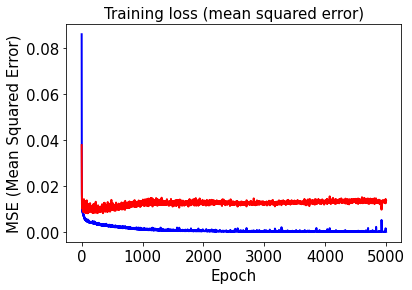

In [25]:
hist = history.history
plt.plot(hist['loss'], lw=2, c='b')
plt.plot(hist['val_loss'], lw=2, c='r')
plt.title('Training loss (mean squared error)', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('MSE (Mean Squared Error)', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

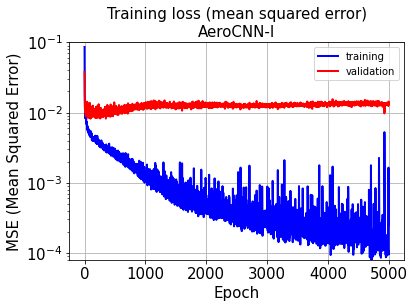

In [26]:
plt.plot(hist['loss'], lw=2, c='b')
plt.plot(hist['val_loss'], lw=2, c='r')
plt.title('Training loss (mean squared error)\nAeroCNN-I', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('MSE (Mean Squared Error)', size=15)
plt.yscale('log')
plt.ylim([8e-5, 1e-1])
plt.legend(['training', 'validation'])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

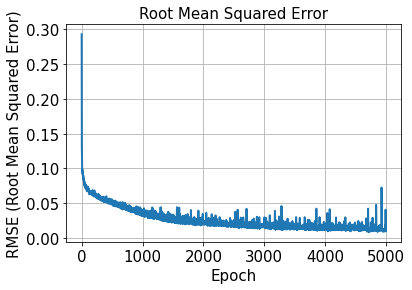

In [27]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('RMSE (Root Mean Squared Error)', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [28]:
test_results = model.evaluate([x_train,aa_train])

42/42 [==============================] - 0s 6ms/step - loss: 3.4757e-06 - rmse: 0.0000e+00


In [29]:
decoded_train = model.predict([x_train,aa_train])

42/42 [==============================] - 7s 8ms/step


In [30]:
decoded_val = model.predict([x_val,aa_val])

18/18 [==============================] - 0s 7ms/step


In [31]:
decoded_test = model.predict([x_test,aa_test])

7/7 [==============================] - 0s 8ms/step


In [32]:
error_train_abs = np.abs(decoded_train - y_train)

In [33]:
error_val_abs = np.abs(decoded_val - y_val)

In [34]:
error_test_abs = np.abs(decoded_test - y_test)

In [35]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [36]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [37]:
error_val_Cl_abs = np.abs(decoded_val[:,0,:] - y_val[:,0,:])

In [38]:
error_val_Cd_abs = np.abs(decoded_val[:,1,:] - y_val[:,1,:])

In [39]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [40]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [41]:
decoded_train.shape

(1328, 2, 1)

In [42]:
os.chdir("D:\\TrainedModels\\20221004")
model.save('AeroCNN-I_2FClayer_withValidationSet_Normalized.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [43]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.019521712552856438


In [44]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.217771536295566


In [45]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.26436144842751125


In [46]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.018330816641798198


In [47]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.038841359312240295


In [48]:
l2_error_Cl_val = np.sqrt(np.sum((decoded_val[:,0,:] - y_val[:,0,:])**2) / np.sum(y_val[:,0,:]**2))
print(l2_error_Cl_val)

0.2098258880505537


In [49]:
l2_error_Cd_val = np.sqrt(np.sum((decoded_val[:,1,:] - y_val[:,1,:])**2) / np.sum(y_val[:,1,:]**2))
print(l2_error_Cd_val)

0.3883052736445873


In [50]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.2616739901498988


In [51]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.3233706795576446


In [52]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.012903235211933144, 0.013706128552694716, 0.015311959430142238, 0.02429087564781594, 0.19874623945900466, 0.04190399034737744, 0.011337614168335742, 0.0071944101422144495, 0.0038203909745480077, 0.0037263231702179844, 0.006521054088218834, 0.0020392782647641154, 0.003126500467170189, 0.006498830679944834, 0.0048786647575211435, 0.005238579617007678, 0.0073555578756535345, 0.006771880734277997, 0.0194589678943583, 0.008511920348138847, 0.026638173516734396, 0.38573169859635764, 0.037458944142984736, 0.018569688681834083, 0.011790328644901718, 0.005083947300128861, 0.01570091216271876, 0.03316824709062715, 0.0011720887382021716, 0.006859174382121122, 0.012496855846353917, 0.015146278256281058, 0.05100292638866965, 0.003475353664753851, 0.01519074049570234, 0.014161588949600339, 0.04505823612172172, 0.0877773791373458, 0.01580411361152046, 0.0106226112788285, 0.00607561775293826, 0.006951420446013205, 0.001475012494382621, 0.006117591912252286, 0.005707707624051126, 0.00829331549093726

In [53]:
l2_error_val_list = []
for i in range(0, len(aa_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum(y_val[i]**2))
    l2_error_val_list.append(l2_error_val_data)

In [54]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.7594750362149829, 0.5705193457371469, 0.2250096326005006, 0.13908523489192773, 0.17978543089120333, 0.1673145916802075, 0.030091687046251533, 0.03185041721616564, 0.11273596047583721, 0.25240201219057773, 0.8288841281926572, 0.6601051406112267, 0.2637552271473888, 0.3097403701075583, 0.026685166253530405, 0.08177806708801388, 0.09831128875496072, 0.0677029317311476, 0.01741937023678206, 0.11089253465961303, 3.487842776052959, 0.6729043695327971, 0.43613664021808085, 0.3481966096309329, 0.29431845704029774, 0.24815322025020634, 0.2203019441155207, 0.1907136598338012, 0.13407077578438278, 0.0396529823247432, 0.3369159444419682, 0.3456057467647642, 1.0010646984170433, 0.46136232460720406, 0.2458936848444669, 0.164941700023757, 0.3567431536969365, 0.8343697116760641, 0.18623069259462915, 0.07117467577628617, 0.025363840497301667, 0.10351719297181382, 0.8863232273374102, 0.7693227336391064, 0.4354454050278351, 0.19285231507771006, 0.15511638064757519, 0.31540419925907653, 0.4195081359645

In [55]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.007018259941477729, 0.004399416938581358, 0.011880871311737555, 0.010227295129341594, 0.13594202008550554, 0.032872990552711125, 0.005631219851233607, 0.0032849366914908217, 0.00044369387130837386, 0.0016232184517784357, 0.005263805256587726, 0.0009708977875247592, 0.0013832775712677235, 0.005967570194895616, 0.00449274140097981, 0.0046523300037470735, 0.007532954116859026, 0.005015372867515772, 0.01883132200062403, 0.008422570834716786, 0.02471525977835435, 0.604554487351631, 0.036854682288032826, 0.012397249105152238, 0.011386548795136708, 0.004170747057032376, 0.012436187998456583, 0.034408007349044895, 0.00017418745678779776, 0.0043568554349380255, 0.013247466333504841, 0.015436039093435482, 0.04991296798395288, 0.003229269619954495, 0.012173901246041273, 0.008112665825866155, 0.006851773927857602, 0.06129705003139115, 0.00018026106580332476, 0.00884533418906799, 0.004596241925894778, 0.006763359051787825, 0.00011952160553249494, 0.006050075230346004, 0.005652462737038392, 0.008

In [56]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.31093377404464356, 0.3847699902811176, 0.23602391504288098, 0.31888419774703275, 0.35112193079616444, 0.28913962431752044, 0.22475366939644018, 0.2026058703168142, 0.1364489870829932, 0.11681935091822458, 0.1140030026735488, 0.040973486361462814, 0.046230767459892436, 0.03507807450727698, 0.01958444285174163, 0.017900302204520113, 0.0007777834130070017, 0.0349055512270262, 0.06451936213141177, 0.02126593466307954, 0.1270304348790355, 0.18605778480550372, 0.08896338389750662, 0.2836114295989493, 0.052259981284204025, 0.028483207103160123, 0.05111328658475495, 0.005480753259819509, 0.0036309687532477476, 0.015470329223735844, 0.006486615505174851, 0.013225768270556049, 0.06486513225054309, 0.018042404376297397, 0.22849356371482651, 0.21773289602393694, 0.34700699062056595, 0.3610197977829955, 0.29752020982800664, 0.17508318639338002, 0.1484145552717033, 0.06525429255657862, 0.0561133138216295, 0.028408486500508822, 0.017522870499015405, 0.0011353943343796731, 0.03938867060606984, 3.51

In [57]:
l2_error_Cl_val_list = []
for i in range(0, len(aa_val)):
    l2_error_Cl_val_data = np.sqrt(np.sum((decoded_val[:,0,:][i] - y_val[:,0,:][i])**2) / np.sum(y_val[:,0,:][i]**2))
    l2_error_Cl_val_list.append(l2_error_Cl_val_data)

In [58]:
l2_error_Cd_val_list = []
for i in range(0, len(aa_val)):
    l2_error_Cd_val_data = np.sqrt(np.sum((decoded_val[:,1,:][i] - y_val[:,1,:][i])**2) / np.sum(y_val[:,1,:][i]**2))
    l2_error_Cd_val_list.append(l2_error_Cd_val_data)

In [59]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.7620768699604463, 0.5633471570004253, 0.2217740571784518, 0.13908183962497092, 0.18040443671824138, 0.16164630437143876, 0.013546331859385141, 0.021450847799088787, 0.10987759395096287, 0.24744628896194207, 0.8319198723019854, 0.6588871642104348, 0.27317347700817934, 0.3050606246654919, 0.010114735410536065, 0.058160926110330594, 0.09828370524877975, 0.06709996269403225, 0.011517615673434588, 0.10975196710591706, 5.022884793623927, 0.6748935087223628, 0.4364589606109067, 0.34833226233279385, 0.29440587760758463, 0.24821978017085014, 0.2203773259445132, 0.1907581622672117, 0.13422861632277538, 0.03626477984979862, 0.34373627980063115, 0.339334995595266, 1.0071559060759343, 0.44757151232020265, 0.24372822620609674, 0.16452400037825796, 0.3574996131030776, 0.8494068759758571, 0.1860620491962731, 0.0709313954761381, 0.024555380053096796, 0.10185465801066582, 0.8894884104479535, 0.7731046673037852, 0.41591660527043545, 0.19597014124445408, 0.16163831717600666, 0.33064596832289206, 0.4213

In [60]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.7079030276727357, 0.7828708338173181, 0.5545690843300533, 0.14030104198161786, 0.10468427624187743, 0.2774181173254864, 0.5492800808536238, 0.6782664985113566, 0.6203880455608655, 0.7375785296314498, 0.727093680506854, 0.681732942812932, 0.07005132737392011, 0.35165704992620717, 0.07625909106614291, 0.16795086986094435, 0.12126941584887135, 0.27602266597512654, 0.31378776973986355, 0.2466009488024176, 0.1651737851080567, 0.13148646936795197, 0.08566395040413474, 0.052130216823496105, 0.006673762453234301, 0.06374759861067282, 0.032823636470850445, 0.1461644180148897, 0.0527170950269662, 0.16583804212942307, 0.05742306420399483, 0.37816679059750985, 0.8836315341817116, 0.8473938667503709, 0.5552143366772564, 0.3006307362250109, 0.2552059296785034, 0.28227443346476255, 0.2453802340629002, 0.19506312608392615, 0.2141554844843553, 0.40054083863266415, 0.5982320480561765, 0.6919681460080646, 0.6498382038035827, 0.15246728741164176, 0.07671463643792209, 0.17193001731415414, 0.362895905421

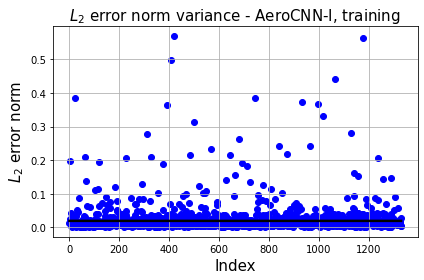

In [61]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, training', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

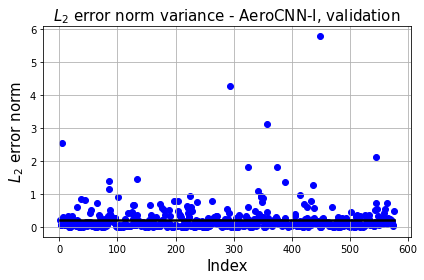

In [62]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_val*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, validation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

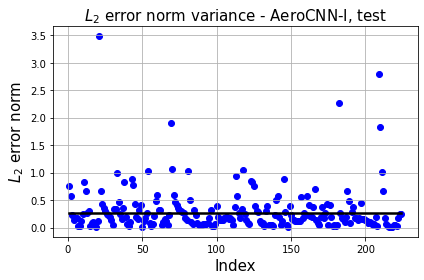

In [63]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

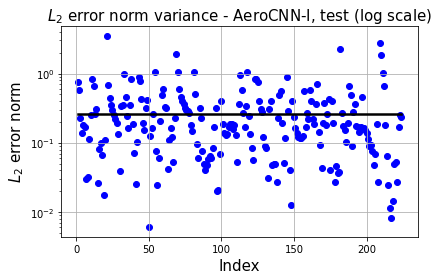

In [64]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

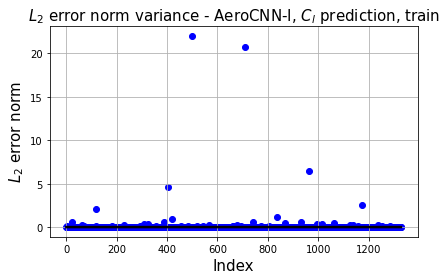

In [65]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

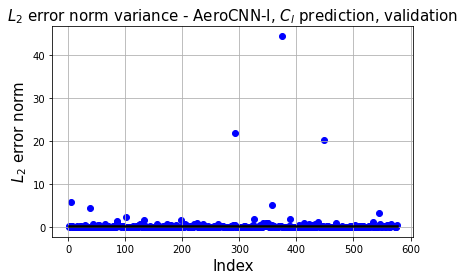

In [66]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_Cl_val*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_Cl_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, validation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

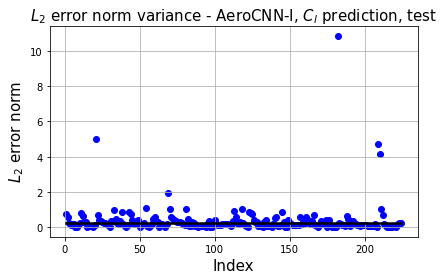

In [67]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

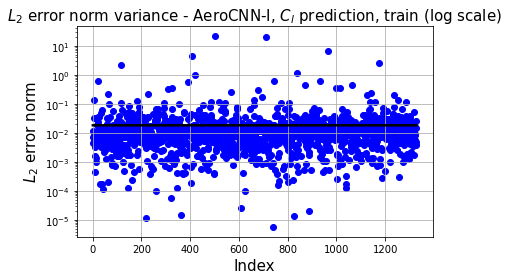

In [68]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

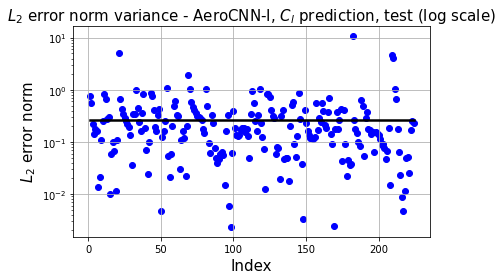

In [69]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

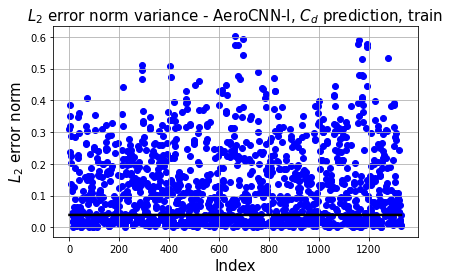

In [70]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

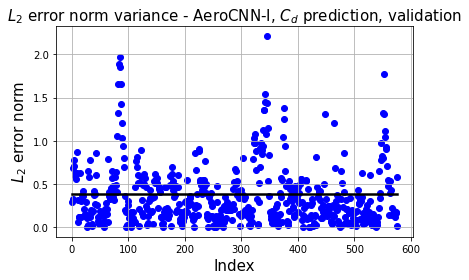

In [71]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_Cd_val*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_Cd_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, validation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

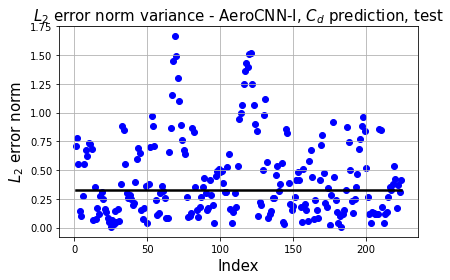

In [72]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

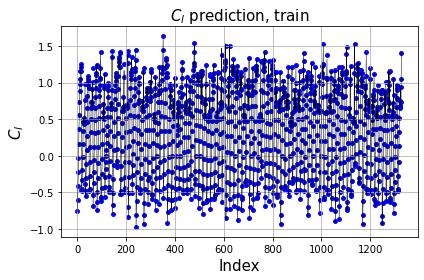

In [73]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

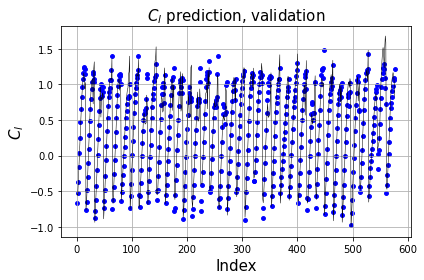

In [74]:
plt.plot(np.linspace(1, decoded_val.shape[0], decoded_val.shape[0]), y_val[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_val.shape[0], decoded_val.shape[0]), decoded_val[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, validation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

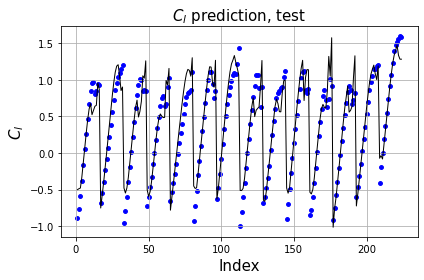

In [75]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

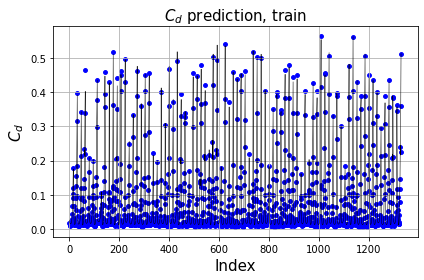

In [76]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

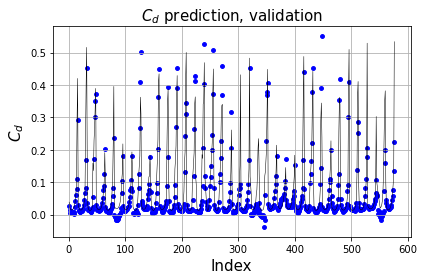

In [77]:
plt.plot(np.linspace(1, decoded_val.shape[0], decoded_val.shape[0]), y_val[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_val.shape[0], decoded_val.shape[0]), decoded_val[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, validation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

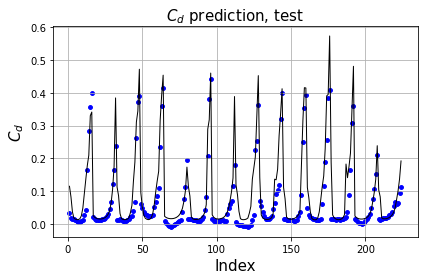

In [78]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

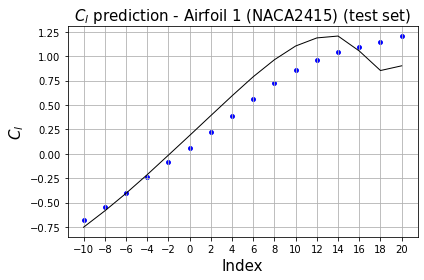

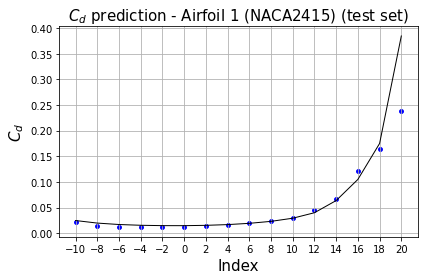

In [79]:
airfoiltest1_predict = decoded_test[16*1:16*2]

airfoiltest1_cl=y_test[16*1:16*2,0,:]
airfoiltest1_cd=y_test[16*1:16*2,1,:]

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 1 (%s) (test set)' % (str(geo_test[1*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 1 (%s) (test set)' % (str(geo_test[1*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [80]:
decoded_test.shape

(224, 2, 1)

In [81]:
np.unique(geo_test)

array([b'NACA001034', b'NACA1408', b'NACA2415', b'NACA2418', b'NACA63210',
       b'NACA632615', b'NACA64108', b'NACA6412', b'NACA64209', b'RAE101',
       b'RAE5212', b'RAE5214', b'RAE69CK', b'RAF48'], dtype='|S32')

In [82]:
geo_test.shape[0]/16

14.0

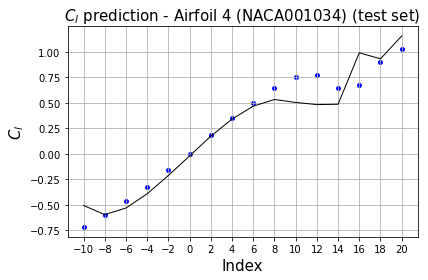

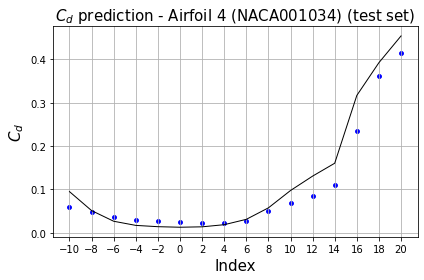

In [83]:
airfoiltest4_predict = decoded_test[16*3:16*4]

airfoiltest4_cl=y_test[16*3:16*4,0,:]
airfoiltest4_cd=y_test[16*3:16*4,1,:]

plt.plot(alpha, airfoiltest4_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest4_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 4 (%s) (test set)' % (str(geo_test[3*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest4_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest4_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 4 (%s) (test set)' % (str(geo_test[3*16][0])[2:-1]), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

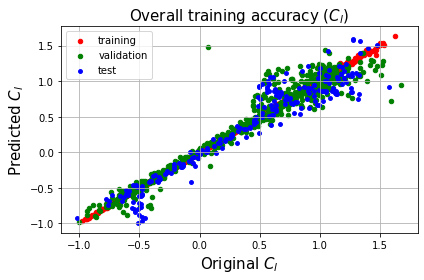

In [84]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_val[:,0,:], decoded_val[:,0,:], c='g', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)', fontsize=15)

plt.grid()
plt.legend(['training', 'validation', 'test'])
plt.tight_layout()
plt.show()

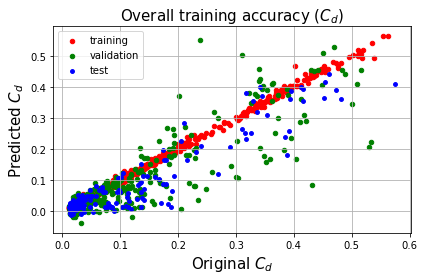

In [85]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_val[:,1,:], decoded_val[:,1,:], c='g', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)', fontsize=15)
plt.grid()
plt.legend(['training', 'validation', 'test'])
plt.tight_layout()
plt.show()